## **Description**



This script is a semi-automated script for subject inclusion/exclusion, preprocessing and ΔERN value extraction.


### Modules and packages

- Python version: 3.15.5  
- Required packages:
    - `mne`
    - `autoreject`
    - `asrpy`
    - `matplotlib`
    - `pandas`
    - `numpy`
    - `csv` 
    - `os` 
- Run the cell below for all imports 

In [1]:
import mne
from mne import preprocessing
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from autoreject import AutoReject
import csv 
from mne.preprocessing import peak_finder
import pandas as pd
from mne import Annotations
import asrpy
import time 
from mne.time_frequency import psd_array_welch
import seaborn as sns
import plotly.express as px

### Data BIDS structure

```text
project_root
├── rawdata
│   └── sub-AG04EN28
│       └── eeg
│           ├── sub-AG04EN28_task-ern_eeg.set
│           ├── sub-AG04EN28_task-ern_channels.tsv
│           └── …
├── derivatives
│   └── ernpipeline
│       ├── plots (For subject-specific ERN plots)
│       │   ├── sub-AG04EN28_plot.png
│       │   ├── sub-CK06ST11_plot.png
│       │   └── …
│       ├── sub-AG04EN28
│       │   ├── sub-AG04EN28_desc-epochs_eeg.fif
│       │   ├── sub-AG04EN28_desc-evokedCorrect_eeg.fif
│       │   ├── sub-AG04EN28_desc-evokedIncorrect_eeg.fif
│       │   ├── sub-AG04EN28_desc-preprocSummary.txt
│       │   └── sub-AG04EN28_desc-ernValues.tsv
│       └── …


The scripts follows a BIDS valid organization and syntax. It creates all the necessary folders for the outputs in your project directory folder. The only path to update will be the root_path to the project directory below. 

In [2]:
######## Setting the paths to fit the BIDS requirements ########

pipeline_name = "ernpipeline"  # change this if needed

# Set the root path to your project directory !!
root_path = "/Users/zayneb/Desktop/eegmanyanalysts"

# Base directories
paths = {
    "raw": os.path.join(root_path, "raw"),
    "deriv": os.path.join(root_path, "derivatives", pipeline_name),
    "plots": os.path.join(root_path, "derivatives", pipeline_name, "plots"),
    "results": os.path.join(root_path, "results")
}

os.makedirs(paths["plots"], exist_ok=True)
os.makedirs(paths["results"], exist_ok=True)

# Utility functions to construct paths (BIDS compliant - adjust if necessary)

def raw_set_path(participant):
    return os.path.join(paths["raw"], participant, "eeg", f"{participant}_task-Flanker_eeg.set")

def events_json_path(participant):
    return os.path.join(paths["raw"], participant, "eeg", f"{participant}_task-Flanker_events.json")

def participant_dir(participant):
    return os.path.join(paths["deriv"], f"{participant}")

def epochs_file(participant):
    return os.path.join(participant_dir(participant), f"{participant}_desc-epochs_eeg.fif")

def evoked_file(participant, kind):  # kind in ['Correct', 'Incorrect', 'dif']
    suffix = {
        'Correct': '_desc-evokedCorrect_eeg.fif',
        'Incorrect': '_desc-evokedIncorrect_eeg.fif',
        'dif': '_desc-evokedDiff_eeg.fif'
    }[kind]
    return os.path.join(participant_dir(participant), suffix.replace('-', f"-{participant}-"))

def summary_txt_path(participant):
    return os.path.join(participant_dir(participant), f"{participant}_desc-preprocSummary.txt")

def ern_values_tsv(participant):
    return os.path.join(participant_dir(participant), f"{participant}_desc-ernValues.tsv")

def out_plot(participant):
    return os.path.join(paths["plots"], f"{participant}")



In [3]:
######## Gather participantects from raw folder )
# Only include directories starting with 'sub-'
files = [d for d in os.listdir(paths["raw"]) \
                if d.startswith("sub-") and os.path.isdir(os.path.join(paths["raw"], d))]
print(files)

['sub-ES06NK11', 'sub-EN05ED14', 'sub-RT04KE01', 'sub-VA05AS27', 'sub-LS08LF22', 'sub-KE07NZ01', 'sub-SA05AH22', 'sub-ER05AS20', 'sub-NN08ER22', 'sub-US08RI28', 'sub-ER07ND12', 'sub-RS06RS22', 'sub-ER09AS01', 'sub-SE05ZI24', 'sub-ER06AN07', 'sub-CK07NK21', 'sub-OW06NZ10', 'sub-DE05LI03', 'sub-RT06AN02', 'sub-ER06IS22', 'sub-EP05EN09', 'sub-EN05KT02', 'sub-VA06OV12', 'sub-TA03RL11', 'sub-EN05AN14', 'sub-ER05LM21', 'sub-IN05ED23', 'sub-NA04OV25', 'sub-ER03ER09', 'sub-ES09LD08', 'sub-LE08AS07', 'sub-TT06LF28', 'sub-ER08AH23', 'sub-EL06EL11', 'sub-ER06US24', 'sub-GT05AS11', 'sub-KE04NI10', 'sub-EL06LD17', 'sub-RT07LD06', 'sub-DT07ES22', 'sub-ER05IM29', 'sub-ER06LS23', 'sub-KA06EK01', 'sub-ER05AV01', 'sub-MA06LO21', 'sub-CK04NS18', 'sub-ER07LF01', 'sub-CH06UT07', 'sub-NN08AS03', 'sub-RK05EF01', 'sub-AT06ED25', 'sub-UZ03IO20', 'sub-RS07LF20', 'sub-NY04DT26', 'sub-NN08EL29', 'sub-ID06US10', 'sub-TE03AS11', 'sub-EZ04SE15', 'sub-GY06LO26', 'sub-VA08AT22', 'sub-ER07ER30', 'sub-RG05RS16', 'sub-LY

## **Subject quality check for inclusion/exclusion**

This section allows to perfrom a semi-automatic quality control across all subjects using four quality metrics (OHA, THV, CHV, BCR) (Extracted from Automagic's pipeline [DOI:http://dx.doi.org/10.1101/460469doi]). Based on these metrics, subjects are labeled into categories **("Good", "OK", "Bad)**. Subjects labeled as "Bad" are excluded from all subsequent analysis to ensure data reliability. 
Note that the classification thresholds are not fixed, they are based on the distribution of the metrics within the dataset and should be **manually adjusted** to fit each specific dataset. 

In [4]:
subject_list = files

######## Defining a function that computes our 3 metrics of interest
def compute_oha_thv_chv(raw, theta_oha, theta_thv, theta_chv, window_s=1.0, step_s=0.5):
    
    # Extraction EEG data (n_chan × n_times)
    picks = mne.pick_types(raw.info, eeg=True, meg=False)
    data = raw.get_data(picks=picks)             
    sfreq = raw.info['sfreq']

    # OHA : Overall High Amplitude
    oha = np.mean(np.abs(data) > theta_oha)          

    # THV : Timepoints of high variance
    w = int(window_s * sfreq)
    st = int(step_s  * sfreq)
    n_win = n_bad = 0
    for start in range(0, data.shape[1] - w + 1, st):
        seg = data[:, start:start + w]               
        n_win += 1
        std_ch_t = np.nanstd(seg, axis=0)          
        if np.any(std_ch_t > theta_thv):
            n_bad += 1
    thv = n_bad / n_win if n_win > 0 else np.nan

    # CHV : Channels of high variance
    chan_sd = np.nanstd(data, axis=1)                
    chv = np.mean(chan_sd > theta_chv)              

    return oha, thv, chv

######## Loading the data
qc_rows = []

######## Loop on all subjects 

for participant in subject_list : 
    
    # load subject
    raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
    unused_channels = ['MASTl','MASTr']
    raw = raw.drop_channels(unused_channels)

    # Adding HEOG as EOG
    heog_data = raw.copy().pick_channels(['F7','F8']).get_data()
    heog = heog_data[0] - heog_data[1]
    heog_info = mne.create_info(['HEOG'], raw.info['sfreq'], 'eog')
    heog_raw = mne.io.RawArray(heog[np.newaxis,:], heog_info)
    raw_heog = raw.copy()
    raw_heog = raw_heog.add_channels([heog_raw], force_update_info=True)
  
    # automatically detect bad channels using Local Outlier Factof (LOF), interpolate and keep them
    bad_channels = mne.preprocessing.find_bad_channels_lof(raw_heog, n_neighbors=20, picks=None, metric="euclidean", threshold=1.5, return_scores=False, verbose=None)
    bad_channels_raw = raw_heog.copy()
    for ch in bad_channels:
        if ch not in raw.info["bads"]:
            bad_channels_raw.info["bads"].append(ch)

    # computing the ratio of bad channels to good channels (BCR)
    n_bads = len(bad_channels_raw.info["bads"])
    n_eeg = len(mne.pick_types(raw.info, eeg=True))
    n_goods = n_eeg - n_bads
    BCR = n_bads / n_goods
    
    # Rereferencing to average 
    bad_channels_raw.set_eeg_reference('average')

    # filtering to remove slow drifts
    filt_raw = bad_channels_raw.copy()
    filt_raw.load_data().filter(l_freq=1., h_freq=None)

    # compute OHA at 30µV
    oha30, _, _ = compute_oha_thv_chv(filt_raw, theta_oha=30e-6, theta_thv=30e-6, theta_chv=30e-6)
    # compute THV and CHV  at 15µV
    _, thv15, chv15 = compute_oha_thv_chv(filt_raw, theta_oha=15e-6, theta_thv=15e-6, theta_chv=15e-6)

    qc_rows.append({
        'sub':    participant,
        'OHA_30': oha30*100,
        'THV_15': thv15*100,
        'CHV_15': chv15*100,
        'BCR' : BCR*100
    })

######## build DataFrame
qc_df = pd.DataFrame(qc_rows)
df = qc_df.copy()



/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106151
    Range : 0 ... 106150 =      0.000 ...   424.600 secs
Ready.


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF4', 'F3', 'F6', 'F7', 'FC5', 'C2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=122089
    Range : 0 ... 122088 =      0.000 ...   488.352 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['FC3', 'FC2', 'TP7', 'TP8', 'CP6', 'CP4', 'P7', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104190
    Range : 0 ... 104189 =      0.000 ...   416.756 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'F3', 'C2', 'P1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95211
    Range : 0 ... 95210 =      0.000 ...   380.840 secs
Ready.
LOF: Detected bad channel(s): ['C5', 'TP7', 'CP2', 'P2', 'P8', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104816
    Range : 0 ... 104815 =      0.000 ...   419.260 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'AF3', 'AF4', 'F2', 'F4', 'C3', 'C5', 'C6', 'CP4', 'CP2', 'P4', 'O1', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104587
    Range : 0 ... 104586 =      0.000 ...   418.344 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'F5', 'F7', 'FT7', 'FT8', 'FC6', 'T7', 'T8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=105562
    Range : 0 ... 105561 =      0.000 ...   422.244 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=88970
    Range : 0 ... 88969 =      0.000 ...   355.876 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=108440
    Range : 0 ... 108439 =      0.000 ...   433.756 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'F1', 'CP1', 'P2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=110425
    Range : 0 ... 110424 =      0.000 ...   441.696 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['FP1', 'AF7', 'AF8', 'F4', 'FT7', 'FC5', 'FC6', 'FC3', 'FC1', 'C2', 'C4', 'T7', 'CP5', 'CP6', 'PO7', 'PO8', 'PO3', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=127877
    Range : 0 ... 127876 =      0.000 ...   511.504 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'F8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95454
    Range : 0 ... 95453 =      0.000 ...   381.812 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94405
    Range : 0 ... 94404 =      0.000 ...   377.616 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'F5', 'FT8', 'FC5', 'C4', 'C6', 'CP1', 'CP2', 'P5', 'PZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95889
    Range : 0 ... 95888 =      0.000 ...   383.552 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'C4', 'TP8', 'P6', 'PO8', 'PO4', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106286
    Range : 0 ... 106285 =      0.000 ...   425.140 secs
Ready.
LOF: Detected bad channel(s): ['F6', 'FT8', 'FC5', 'FC3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104727
    Range : 0 ... 104726 =      0.000 ...   418.904 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'F8', 'P1', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99113
    Range : 0 ... 99112 =      0.000 ...   396.448 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'T8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101549
    Range : 0 ... 101548 =      0.000 ...   406.192 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'F3', 'FT8', 'FC6', 'FC1', 'CP5', 'P1', 'PO3', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100883
    Range : 0 ... 100882 =      0.000 ...   403.528 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=90406
    Range : 0 ... 90405 =      0.000 ...   361.620 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'F5', 'FC2', 'C1', 'TP8', 'PO7', 'O2', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102993
    Range : 0 ... 102992 =      0.000 ...   411.968 secs
Ready.
LOF: Detected bad channel(s): ['TP7', 'PO7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98531
    Range : 0 ... 98530 =      0.000 ...   394.120 secs
Ready.
LOF: Detected bad channel(s): ['FC2', 'C3', 'CP1', 'P8', 'PO8', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96513
    Range : 0 ... 96512 =      0.000 ...   386.048 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'FC2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=121768
    Range : 0 ... 121767 =      0.000 ...   487.068 secs
Ready.
LOF: Detected bad channel(s): ['T7', 'T8', 'P8', 'PO7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102940
    Range : 0 ... 102939 =      0.000 ...   411.756 secs
Ready.
LOF: Detected bad channel(s): ['FC6', 'FC1', 'TP7', 'CP5', 'CP4', 'P1', 'P2', 'P3', 'P4', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=108438
    Range : 0 ... 108437 =      0.000 ...   433.748 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF8', 'F3', 'F5', 'F8', 'C3', 'C4', 'P3', 'P4', 'P7', 'PO8', 'PO4', 'CZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97689
    Range : 0 ... 97688 =      0.000 ...   390.752 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'F4', 'FC4', 'FC2', 'T8', 'P5', 'P6', 'PO8', 'PO3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96361
    Range : 0 ... 96360 =      0.000 ...   385.440 secs
Ready.
LOF: Detected bad channel(s): ['FC4', 'C4']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=103720
    Range : 0 ... 103719 =      0.000 ...   414.876 secs
Ready.
LOF: Detected bad channel(s): ['F7', 'FC2', 'C2', 'C6', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97868
    Range : 0 ... 97867 =      0.000 ...   391.468 secs
Ready.
LOF: Detected bad channel(s): ['AF4', 'F4', 'F8', 'FC5', 'C1', 'C3', 'C5', 'T7', 'T8', 'CP4', 'P6', 'POZ', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95392
    Range : 0 ... 95391 =      0.000 ...   381.564 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'FC6', 'C1', 'C2', 'TP7', 'CP2', 'P2', 'P3', 'O2', 'CPZ', 'FZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=105034
    Range : 0 ... 105033 =      0.000 ...   420.132 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'F6', 'FT8', 'FC6', 'FC2', 'T7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101419
    Range : 0 ... 101418 =      0.000 ...   405.672 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'F7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98231
    Range : 0 ... 98230 =      0.000 ...   392.920 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF3', 'F4', 'FC5', 'CP3', 'O2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106556
    Range : 0 ... 106555 =      0.000 ...   426.220 secs
Ready.
LOF: Detected bad channel(s): ['F4', 'FC3', 'C1', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98492
    Range : 0 ... 98491 =      0.000 ...   393.964 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'F4', 'FC6', 'FC3', 'FC1', 'FC2', 'TP8', 'CP5', 'CP3', 'CP4', 'CP2', 'P7', 'O2', 'CPZ', 'CZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96526
    Range : 0 ... 96525 =      0.000 ...   386.100 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'F4', 'F7', 'FC3', 'T8', 'CP5', 'PO7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106494
    Range : 0 ... 106493 =      0.000 ...   425.972 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'FT7', 'FT8', 'CP4', 'CP1', 'PO4', 'O2', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102476
    Range : 0 ... 102475 =      0.000 ...   409.900 secs
Ready.
LOF: Detected bad channel(s): ['F5', 'FC3', 'FC4', 'C1', 'CP3', 'P7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93583
    Range : 0 ... 93582 =      0.000 ...   374.328 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'F6', 'F8', 'C2', 'P1', 'P7', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94472
    Range : 0 ... 94471 =      0.000 ...   377.884 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['AF4', 'CP3', 'O2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96226
    Range : 0 ... 96225 =      0.000 ...   384.900 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F7', 'CP3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98675
    Range : 0 ... 98674 =      0.000 ...   394.696 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF3', 'F5', 'FC6', 'FC4', 'C5', 'C6', 'T8', 'TP7', 'P2', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106630
    Range : 0 ... 106629 =      0.000 ...   426.516 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'C2', 'P2', 'PO4', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95831
    Range : 0 ... 95830 =      0.000 ...   383.320 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F7', 'CP1', 'CP2', 'CPZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95802
    Range : 0 ... 95801 =      0.000 ...   383.204 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'F7', 'C4', 'CP5', 'CP2', 'P7', 'O2', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95474
    Range : 0 ... 95473 =      0.000 ...   381.892 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF8', 'F2', 'F3', 'F4', 'F5', 'F6', 'FT7', 'FT8', 'FC5', 'FC3', 'FC4', 'FC1', 'FC2', 'C2', 'C4', 'T7', 'CP1', 'PO3', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102154
    Range : 0 ... 102153 =      0.000 ...   408.612 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['AF4', 'F2', 'T7', 'CP1', 'P5', 'PO7', 'POZ', 'PZ', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101295
    Range : 0 ... 101294 =      0.000 ...   405.176 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'F7', 'F8', 'FT8', 'P5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these e

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96547
    Range : 0 ... 96546 =      0.000 ...   386.184 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF4', 'F5', 'F7', 'CP5', 'CP3', 'CP1', 'P6', 'P7', 'PO7', 'O2', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100793
    Range : 0 ... 100792 =      0.000 ...   403.168 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['FP1', 'F1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=111482
    Range : 0 ... 111481 =      0.000 ...   445.924 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF4', 'F4', 'F5', 'F6', 'F7', 'F8', 'FT8', 'FC6', 'FC3', 'C1', 'C2', 'T7', 'TP7', 'CP5', 'P5', 'PO4', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99645
    Range : 0 ... 99644 =      0.000 ...   398.576 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'T8', 'CP5', 'CP1', 'O2', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98533
    Range : 0 ... 98532 =      0.000 ...   394.128 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['AF3', 'F4', 'FT7', 'FT8', 'C5', 'T7', 'P6', 'P8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96540
    Range : 0 ... 96539 =      0.000 ...   386.156 secs
Ready.
LOF: Detected bad channel(s): ['AF3', 'P5', 'P7', 'PO7', 'PO8', 'PO4', 'O2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95151
    Range : 0 ... 95150 =      0.000 ...   380.600 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF4', 'FC2', 'C2', 'T8', 'P2', 'P4', 'P6', 'O2', 'CPZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99428
    Range : 0 ... 99427 =      0.000 ...   397.708 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'P7', 'PO7', 'OZ', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=108198
    Range : 0 ... 108197 =      0.000 ...   432.788 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95900
    Range : 0 ... 95899 =      0.000 ...   383.596 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'F3', 'FC3', 'CP3', 'CP1', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=107802
    Range : 0 ... 107801 =      0.000 ...   431.204 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['AF7', 'F2', 'F4', 'F8', 'FT7', 'FC5', 'FC6', 'FC3', 'FC1', 'FC2', 'C2', 'C3', 'C4', 'C6', 'CP5', 'CP6', 'CP3', 'CP1', 'P1', 'P2', 'P6', 'PO3', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.2s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101765
    Range : 0 ... 101764 =      0.000 ...   407.056 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99563
    Range : 0 ... 99562 =      0.000 ...   398.248 secs
Ready.
LOF: Detected bad channel(s): ['FT8', 'C1', 'C2', 'CP6']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=113644
    Range : 0 ... 113643 =      0.000 ...   454.572 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'AF4', 'F6', 'F7', 'FC5', 'C5', 'P3', 'PO3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96049
    Range : 0 ... 96048 =      0.000 ...   384.192 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F7', 'F8', 'FC2', 'C4', 'C5', 'TP8', 'CP6', 'CP3', 'CP4', 'P5', 'P6', 'P8', 'PO8', 'PO3', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.2s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100045
    Range : 0 ... 100044 =      0.000 ...   400.176 secs
Ready.
LOF: Detected bad channel(s): ['FC5', 'FC4', 'P3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=105750
    Range : 0 ... 105749 =      0.000 ...   422.996 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'F3', 'C1', 'C2', 'P4', 'PO4']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97542
    Range : 0 ... 97541 =      0.000 ...   390.164 secs
Ready.
LOF: Detected bad channel(s): ['FC3', 'PO7', 'PO3', 'O1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99539
    Range : 0 ... 99538 =      0.000 ...   398.152 secs
Ready.
LOF: Detected bad channel(s): ['AF3', 'F4', 'F6', 'F7', 'CP6', 'CP4', 'CP1', 'P6', 'PO3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95187
    Range : 0 ... 95186 =      0.000 ...   380.744 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'F6', 'FT8', 'TP8', 'P5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=103518
    Range : 0 ... 103517 =      0.000 ...   414.068 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95743
    Range : 0 ... 95742 =      0.000 ...   382.968 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['FT7', 'FT8', 'C4', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99715
    Range : 0 ... 99714 =      0.000 ...   398.856 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'FT8', 'FC2', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101606
    Range : 0 ... 101605 =      0.000 ...   406.420 secs
Ready.
LOF: Detected bad channel(s): ['AF4', 'F5', 'F7', 'FC5', 'FC3', 'C3', 'T7', 'CP6', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Creating RawArray with float64 data, n_channels=1, n_times=93884
    Range : 0 ... 93883 =      0.000 ...   375.532 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'FC4', 'CP5', 'CP2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101647
    Range : 0 ... 101646 =      0.000 ...   406.584 secs
Ready.
LOF: Detected bad channel(s): ['CP4']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106047
    Range : 0 ... 106046 =      0.000 ...   424.184 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['AF3', 'F1', 'F3', 'F4', 'F7', 'F8', 'C2', 'T8', 'P2', 'P8', 'PO8', 'PO3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102051
    Range : 0 ... 102050 =      0.000 ...   408.200 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'F5', 'T7', 'TP7', 'P7', 'PO7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=91963
    Range : 0 ... 91962 =      0.000 ...   367.848 secs
Ready.
LOF: Detected bad channel(s): ['C3', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94077
    Range : 0 ... 94076 =      0.000 ...   376.304 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'FT7', 'C4', 'T7', 'PO7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96168
    Range : 0 ... 96167 =      0.000 ...   384.668 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F2', 'FC1', 'FC2', 'T7', 'T8', 'TP8', 'CP3', 'CP4', 'CZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102065
    Range : 0 ... 102064 =      0.000 ...   408.256 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'C3', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93658
    Range : 0 ... 93657 =      0.000 ...   374.628 secs
Ready.
LOF: Detected bad channel(s): ['F3', 'F7', 'FC3', 'T8', 'CP4', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97940
    Range : 0 ... 97939 =      0.000 ...   391.756 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FC3', 'FC2', 'C2', 'C3', 'CP1', 'CP2', 'P4', 'PO3', 'PO4', 'PZ', 'CZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102520
    Range : 0 ... 102519 =      0.000 ...   410.076 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'AF4', 'F4', 'F8', 'FT8', 'TP7', 'P1', 'P8', 'O2']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101900
    Range : 0 ... 101899 =      0.000 ...   407.596 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F8', 'FT8', 'C2', 'P6', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102818
    Range : 0 ... 102817 =      0.000 ...   411.268 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'TP7', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=105972
    Range : 0 ... 105971 =      0.000 ...   423.884 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'FT7', 'FT8', 'FC6', 'C2', 'C4', 'T8', 'TP8', 'CP5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97788
    Range : 0 ... 97787 =      0.000 ...   391.148 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'FC5', 'FC2', 'C3', 'C5', 'C6', 'T7', 'T8', 'TP7', 'CP5', 'CP3', 'CP2', 'O1', 'O2', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=109952
    Range : 0 ... 109951 =      0.000 ...   439.804 secs
Ready.
LOF: Detected bad channel(s): ['AF4', 'F8', 'FT8', 'CPZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97830
    Range : 0 ... 97829 =      0.000 ...   391.316 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'FC6', 'FC4', 'CP2', 'PO7', 'CZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100345
    Range : 0 ... 100344 =      0.000 ...   401.376 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF4', 'F5', 'F7', 'FT7', 'FC5', 'C5', 'P3', 'PO3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101582
    Range : 0 ... 101581 =      0.000 ...   406.324 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F2', 'F6', 'FT8', 'FC2', 'P3', 'P5', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=107697
    Range : 0 ... 107696 =      0.000 ...   430.784 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'AF3', 'AF4', 'F2', 'F4', 'FC6', 'FC1', 'C4', 'TP8', 'CP4', 'P2', 'P8', 'PO4', 'O2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101704
    Range : 0 ... 101703 =      0.000 ...   406.812 secs
Ready.
LOF: Detected bad channel(s): ['O1', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101361
    Range : 0 ... 101360 =      0.000 ...   405.440 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'AF3', 'F6', 'T7', 'CP5', 'O2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=91200
    Range : 0 ... 91199 =      0.000 ...   364.796 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF4', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97939
    Range : 0 ... 97938 =      0.000 ...   391.752 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'F8', 'FT8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99405
    Range : 0 ... 99404 =      0.000 ...   397.616 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F4', 'F6', 'F7', 'FC3', 'TP7', 'TP8', 'P6', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102246
    Range : 0 ... 102245 =      0.000 ...   408.980 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'F7', 'F8', 'FC6', 'TP8', 'CP5', 'CP6', 'P3', 'P5', 'P7', 'P8', 'PO7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97788
    Range : 0 ... 97787 =      0.000 ...   391.148 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'FC6', 'C6', 'P4', 'P6', 'P8', 'PO7', 'PO8', 'PO4', 'O2', 'OZ', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=103275
    Range : 0 ... 103274 =      0.000 ...   413.096 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'F2', 'F4', 'F7', 'F8', 'FC4', 'FC1', 'C1', 'C3', 'TP7', 'PO8', 'FZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106873
    Range : 0 ... 106872 =      0.000 ...   427.488 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['AF7', 'AF3', 'F1', 'F2', 'FC3', 'FC1', 'C3', 'C4', 'C6', 'CP4', 'P4', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100151
    Range : 0 ... 100150 =      0.000 ...   400.600 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'CP5', 'P3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98974
    Range : 0 ... 98973 =      0.000 ...   395.892 secs
Ready.
LOF: Detected bad channel(s): ['AF4', 'F6', 'F7', 'FC6', 'TP7', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97493
    Range : 0 ... 97492 =      0.000 ...   389.968 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=108424
    Range : 0 ... 108423 =      0.000 ...   433.692 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['AF8', 'F1', 'FC5', 'FC1', 'C3', 'C6', 'CP6', 'CP3', 'P1', 'P8', 'PO3', 'PO4', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96414
    Range : 0 ... 96413 =      0.000 ...   385.652 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'F1', 'FC6', 'TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106838
    Range : 0 ... 106837 =      0.000 ...   427.348 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF8', 'AF4', 'F1', 'F5', 'F6', 'F7', 'F8', 'FT8', 'FC6', 'C2', 'C6', 'T8', 'CP4', 'P2', 'P5', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95969
    Range : 0 ... 95968 =      0.000 ...   383.872 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'FC6', 'FC4', 'FC1', 'FC2', 'C1', 'C3', 'TP7', 'CP4', 'CP2', 'O1', 'CPZ', 'CZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96105
    Range : 0 ... 96104 =      0.000 ...   384.416 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF4', 'P7', 'PO7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104045
    Range : 0 ... 104044 =      0.000 ...   416.176 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F3', 'F6', 'F8', 'FT8', 'FC4', 'FC1', 'FC2', 'C2', 'TP8', 'CP4', 'P3', 'P5', 'PO3', 'PO4', 'POZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96060
    Range : 0 ... 96059 =      0.000 ...   384.236 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'F1', 'P1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=92622
    Range : 0 ... 92621 =      0.000 ...   370.484 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'AF4', 'FC1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104655
    Range : 0 ... 104654 =      0.000 ...   418.616 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99993
    Range : 0 ... 99992 =      0.000 ...   399.968 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'F6', 'F7', 'FC4', 'FC2', 'T7', 'TP7', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=103614
    Range : 0 ... 103613 =      0.000 ...   414.452 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F2', 'F3', 'F5', 'FT7', 'FC2', 'CP5', 'P7', 'PO3', 'O1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102308
    Range : 0 ... 102307 =      0.000 ...   409.228 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'C2', 'CP1', 'P8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104323
    Range : 0 ... 104322 =      0.000 ...   417.288 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FC6', 'TP7', 'P3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106273
    Range : 0 ... 106272 =      0.000 ...   425.088 secs
Ready.
LOF: Detected bad channel(s): ['AF4', 'FC3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104129
    Range : 0 ... 104128 =      0.000 ...   416.512 secs
Ready.
LOF: Detected bad channel(s): ['AF3', 'F5', 'FC4', 'FC1', 'C1', 'T8', 'CP3', 'CP1', 'P5', 'PO8', 'O1', 'OZ', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97197
    Range : 0 ... 97196 =      0.000 ...   388.784 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF4', 'F2', 'F6', 'C1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99213
    Range : 0 ... 99212 =      0.000 ...   396.848 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['AF7', 'F1', 'F3', 'F4', 'FC3', 'C4', 'TP7', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104146
    Range : 0 ... 104145 =      0.000 ...   416.580 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'T7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=120317
    Range : 0 ... 120316 =      0.000 ...   481.264 secs
Ready.
LOF: Detected bad channel(s): ['T8', 'P1', 'PO7', 'PO8', 'PO3', 'O1', 'O2', 'OZ', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=103342
    Range : 0 ... 103341 =      0.000 ...   413.364 secs
Ready.
LOF: Detected bad channel(s): ['F4', 'PO7']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94199
    Range : 0 ... 94198 =      0.000 ...   376.792 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'F1', 'F5', 'F6', 'F8', 'FC4', 'FC1', 'C3', 'T8', 'TP7', 'TP8', 'CP1', 'P6', 'P8', 'O1', 'OZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=107683
    Range : 0 ... 107682 =      0.000 ...   430.728 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100471
    Range : 0 ... 100470 =      0.000 ...   401.880 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F2', 'C2', 'TP7', 'TP8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=92719
    Range : 0 ... 92718 =      0.000 ...   370.872 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99745
    Range : 0 ... 99744 =      0.000 ...   398.976 secs
Ready.
LOF: Detected bad channel(s): ['TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98586
    Range : 0 ... 98585 =      0.000 ...   394.340 secs
Ready.
LOF: Detected bad channel(s): ['FP2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98314
    Range : 0 ... 98313 =      0.000 ...   393.252 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'FT8', 'FC5', 'T7', 'OZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94516
    Range : 0 ... 94515 =      0.000 ...   378.060 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF8', 'F3', 'T7', 'TP8', 'CP4', 'P4', 'PO4', 'O1', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95788
    Range : 0 ... 95787 =      0.000 ...   383.148 secs
Ready.
LOF: Detected bad channel(s): ['C3', 'TP8', 'CP6', 'CP1', 'PO4']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102117
    Range : 0 ... 102116 =      0.000 ...   408.464 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FC5', 'FC6', 'C4', 'TP7', 'CP6', 'P2', 'P3', 'P4', 'P6', 'PO8', 'PO4', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102292
    Range : 0 ... 102291 =      0.000 ...   409.164 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'F5', 'F7', 'F8', 'T8', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93983
    Range : 0 ... 93982 =      0.000 ...   375.928 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'F3', 'F5', 'F6', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C2', 'C3', 'C5', 'TP8', 'CP1', 'P2', 'P3', 'O1', 'PZ', 'CZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=89348
    Range : 0 ... 89347 =      0.000 ...   357.388 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'F1', 'F8', 'FC1', 'C5', 'TP8', 'CP6', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101688
    Range : 0 ... 101687 =      0.000 ...   406.748 secs
Ready.
LOF: Detected bad channel(s): ['CP4', 'CP2', 'P7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98489
    Range : 0 ... 98488 =      0.000 ...   393.952 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'C2', 'TP8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96747
    Range : 0 ... 96746 =      0.000 ...   386.984 secs
Ready.
LOF: Detected bad channel(s): ['O1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99252
    Range : 0 ... 99251 =      0.000 ...   397.004 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95710
    Range : 0 ... 95709 =      0.000 ...   382.836 secs
Ready.
LOF: Detected bad channel(s): ['F7', 'FC3', 'C1', 'C2', 'C3', 'TP7', 'CP5', 'P1', 'P3', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93590
    Range : 0 ... 93589 =      0.000 ...   374.356 secs
Ready.
LOF: Detected bad channel(s): ['TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: Runti

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98725
    Range : 0 ... 98724 =      0.000 ...   394.896 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FT7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104744
    Range : 0 ... 104743 =      0.000 ...   418.972 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'F1', 'FT7', 'FC6', 'FC3', 'T7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102376
    Range : 0 ... 102375 =      0.000 ...   409.500 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF8', 'FC1', 'P1', 'POZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95503
    Range : 0 ... 95502 =      0.000 ...   382.008 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'FT8', 'FC6', 'FC2', 'C2', 'C3', 'C5', 'C6', 'TP8', 'CP5', 'CP6', 'CP4', 'CP2', 'P4', 'O2', 'OZ', 'PZ', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101111
    Range : 0 ... 101110 =      0.000 ...   404.440 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F4', 'T8', 'POZ']
EEG channel type selected for re-referencing


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95072
    Range : 0 ... 95071 =      0.000 ...   380.284 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'F2', 'F3', 'F5', 'F6', 'FC4', 'C2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95079
    Range : 0 ... 95078 =      0.000 ...   380.312 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F3', 'F5', 'F7', 'FT7', 'FC3', 'P5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99444
    Range : 0 ... 99443 =      0.000 ...   397.772 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'F7', 'T8', 'CP5', 'PO7', 'O2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96694
    Range : 0 ... 96693 =      0.000 ...   386.772 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98933
    Range : 0 ... 98932 =      0.000 ...   395.728 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'FC2', 'CP2', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94541
    Range : 0 ... 94540 =      0.000 ...   378.160 secs
Ready.
LOF: Detected bad channel(s): ['P5', 'P6', 'PO3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=141476
    Range : 0 ... 141475 =      0.000 ...   565.900 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'F2', 'F3', 'F6', 'F7', 'FT7', 'FT8', 'T8', 'CP2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102336
    Range : 0 ... 102335 =      0.000 ...   409.340 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['F1', 'F3', 'F4', 'FC3', 'C2', 'T7', 'TP8', 'CP4', 'CP2', 'P1', 'PO7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93079
    Range : 0 ... 93078 =      0.000 ...   372.312 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['AF4', 'F4', 'FC3', 'FC4', 'C1', 'C2', 'C3', 'T7', 'CP6', 'CP2', 'PO4', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=88169
    Range : 0 ... 88168 =      0.000 ...   352.672 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'P5', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97919
    Range : 0 ... 97918 =      0.000 ...   391.672 secs
Ready.
LOF: Detected bad channel(s): ['F3', 'F4', 'F6', 'F8', 'FT8', 'FC3', 'FC2', 'C1', 'C5', 'T7', 'CP6', 'CP3', 'CP1', 'P1', 'P5', 'P8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100882
    Range : 0 ... 100881 =      0.000 ...   403.524 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=131577
    Range : 0 ... 131576 =      0.000 ...   526.304 secs
Ready.
LOF: Detected bad channel(s): ['PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=92289
    Range : 0 ... 92288 =      0.000 ...   369.152 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98496
    Range : 0 ... 98495 =      0.000 ...   393.980 secs
Ready.
LOF: Detected bad channel(s): ['AF3', 'C2', 'TP7', 'P3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97229
    Range : 0 ... 97228 =      0.000 ...   388.912 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98522
    Range : 0 ... 98521 =      0.000 ...   394.084 secs
Ready.
LOF: Detected bad channel(s): ['AF4', 'F2', 'F6', 'F8', 'FC5', 'C4', 'T7', 'T8', 'TP7', 'CP5', 'CP6', 'CP3', 'P1', 'P2', 'P8', 'PO7', 'O2', 'POZ', 'PZ', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99843
    Range : 0 ... 99842 =      0.000 ...   399.368 secs
Ready.
LOF: Detected bad channel(s): ['TP8', 'CP3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99935
    Range : 0 ... 99934 =      0.000 ...   399.736 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['T8', 'TP8', 'CP5', 'P3', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=107389
    Range : 0 ... 107388 =      0.000 ...   429.552 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF4', 'F2', 'F3', 'F8', 'FT8', 'FC6', 'FC3', 'C5', 'TP7', 'CP2', 'P5', 'PO7', 'PO8', 'PO4', 'O1', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99960
    Range : 0 ... 99959 =      0.000 ...   399.836 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'T8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=103942
    Range : 0 ... 103941 =      0.000 ...   415.764 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'TP7', 'TP8', 'P5', 'P7', 'PO7', 'O1', 'O2', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95200
    Range : 0 ... 95199 =      0.000 ...   380.796 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'AF4', 'FT8', 'FC3', 'FC2', 'C1', 'T8', 'CP1', 'P5', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=107658
    Range : 0 ... 107657 =      0.000 ...   430.628 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'FC1', 'CP4', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102975
    Range : 0 ... 102974 =      0.000 ...   411.896 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'AF4', 'FC3', 'C1', 'CP1', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100478
    Range : 0 ... 100477 =      0.000 ...   401.908 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF8', 'F5', 'F6', 'F7', 'F8', 'FC5', 'FC4', 'FC2', 'P1', 'P3', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: Runti

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93885
    Range : 0 ... 93884 =      0.000 ...   375.536 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'F4', 'F8', 'FC4', 'C1', 'T7', 'CP2', 'P2', 'P3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100565
    Range : 0 ... 100564 =      0.000 ...   402.256 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'F4', 'PZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101717
    Range : 0 ... 101716 =      0.000 ...   406.864 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'F6', 'F7', 'FT8', 'TP7', 'CP1', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100586
    Range : 0 ... 100585 =      0.000 ...   402.340 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96852
    Range : 0 ... 96851 =      0.000 ...   387.404 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'FC2', 'C1', 'T7', 'T8', 'TP7', 'P8', 'CZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=112503
    Range : 0 ... 112502 =      0.000 ...   450.008 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'F6', 'F8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99336
    Range : 0 ... 99335 =      0.000 ...   397.340 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['F7', 'FC6', 'CP4', 'PO4', 'CPZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94046
    Range : 0 ... 94045 =      0.000 ...   376.180 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'F7', 'FT8', 'T7', 'T8', 'TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101892
    Range : 0 ... 101891 =      0.000 ...   407.564 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'FC3', 'FC1', 'C1', 'C2', 'C3', 'CP6', 'CP3', 'CP2', 'P1', 'P4', 'P7', 'PO8', 'PO4', 'O2', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99747
    Range : 0 ... 99746 =      0.000 ...   398.984 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'FT8', 'C3', 'C5', 'P2', 'P7', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=107442
    Range : 0 ... 107441 =      0.000 ...   429.764 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF8', 'AF3', 'AF4', 'F3', 'F5', 'F6', 'C2', 'T8', 'CP4', 'P6', 'P7', 'PO4']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104234
    Range : 0 ... 104233 =      0.000 ...   416.932 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'F4', 'F5', 'C2', 'P5', 'P7', 'PO7', 'PO8', 'O1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=113701
    Range : 0 ... 113700 =      0.000 ...   454.800 secs
Ready.
LOF: Detected bad channel(s): ['CP2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=108041
    Range : 0 ... 108040 =      0.000 ...   432.160 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'F5', 'F8', 'FC1', 'TP7', 'CP1', 'P4', 'P7', 'P8', 'PO8', 'O2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99276
    Range : 0 ... 99275 =      0.000 ...   397.100 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'AF8', 'AF4', 'F2', 'F5', 'F7', 'FT7', 'FC5', 'FC2', 'C4', 'T7', 'TP8', 'CP5', 'CP1', 'CP2', 'P3', 'P4', 'P7', 'PO7', 'PO3', 'O1', 'PZ', 'CPZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104424
    Range : 0 ... 104423 =      0.000 ...   417.692 secs
Ready.
LOF: Detected bad channel(s): ['F4', 'F5', 'T8', 'CP3', 'P1', 'P4', 'P7', 'P8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97682
    Range : 0 ... 97681 =      0.000 ...   390.724 secs
Ready.
LOF: Detected bad channel(s): ['T7', 'T8', 'TP8', 'P2', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=119972
    Range : 0 ... 119971 =      0.000 ...   479.884 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=115171
    Range : 0 ... 115170 =      0.000 ...   460.680 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96880
    Range : 0 ... 96879 =      0.000 ...   387.516 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'C1', 'PO8', 'PO3', 'O1', 'O2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97605
    Range : 0 ... 97604 =      0.000 ...   390.416 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'FC2', 'C4', 'C6', 'TP8', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104936
    Range : 0 ... 104935 =      0.000 ...   419.740 secs
Ready.
LOF: Detected bad channel(s): ['FC5', 'TP7', 'PO3', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=129288
    Range : 0 ... 129287 =      0.000 ...   517.148 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['FP1', 'AF7', 'AF3', 'F1', 'F4', 'F7', 'FC5', 'FC4', 'FC1', 'C3', 'C5', 'P8', 'PO7', 'O2', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97899
    Range : 0 ... 97898 =      0.000 ...   391.592 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97267
    Range : 0 ... 97266 =      0.000 ...   389.064 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['F7', 'C3', 'T8', 'TP8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95868
    Range : 0 ... 95867 =      0.000 ...   383.468 secs
Ready.
LOF: Detected bad channel(s): ['AF3', 'F3', 'F7', 'F8', 'FC4', 'FC2', 'C4', 'C6', 'CP3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94841
    Range : 0 ... 94840 =      0.000 ...   379.360 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'F2', 'F4', 'F7', 'FC3', 'FC4', 'FC1', 'C1', 'PO7', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101794
    Range : 0 ... 101793 =      0.000 ...   407.172 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'TP8', 'CP6', 'CP4', 'CP2', 'P7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99985
    Range : 0 ... 99984 =      0.000 ...   399.936 secs
Ready.
LOF: Detected bad channel(s): ['F6', 'F8', 'C6']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99257
    Range : 0 ... 99256 =      0.000 ...   397.024 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'F2', 'F3', 'F8', 'FT7', 'FT8', 'FC5', 'FC3', 'T8', 'TP7', 'CP4', 'P8', 'POZ', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100108
    Range : 0 ... 100107 =      0.000 ...   400.428 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'F3', 'F7', 'FC5', 'FC3', 'C2', 'TP7', 'P7', 'PO7', 'PZ', 'CPZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98415
    Range : 0 ... 98414 =      0.000 ...   393.656 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'F4', 'F6', 'F8', 'FC6', 'C6', 'T8', 'TP7', 'TP8', 'CP4', 'OZ', 'PZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104648
    Range : 0 ... 104647 =      0.000 ...   418.588 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'F3', 'F6', 'FC6', 'TP7', 'P6', 'P8', 'PO3']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98657
    Range : 0 ... 98656 =      0.000 ...   394.624 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98621
    Range : 0 ... 98620 =      0.000 ...   394.480 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF4', 'F1', 'F6', 'FT8', 'FC2', 'P3']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96943
    Range : 0 ... 96942 =      0.000 ...   387.768 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'F4', 'F5', 'FT8', 'FC5', 'CP5', 'CP6', 'P3', 'O1', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=110267
    Range : 0 ... 110266 =      0.000 ...   441.064 secs
Ready.
LOF: Detected bad channel(s): ['CP5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=92483
    Range : 0 ... 92482 =      0.000 ...   369.928 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'TP7', 'TP8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99206
    Range : 0 ... 99205 =      0.000 ...   396.820 secs
Ready.
LOF: Detected bad channel(s): ['F6', 'FC5', 'FC4', 'FC2', 'C2', 'C4', 'TP8', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'PO8', 'O2', 'PZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99731
    Range : 0 ... 99730 =      0.000 ...   398.920 secs
Ready.
LOF: Detected bad channel(s): ['AF3', 'F5', 'F8', 'FT8', 'CP3', 'CP4', 'CP1', 'P1', 'P2', 'P3', 'P6', 'P8', 'PO7', 'PO8', 'O1', 'OZ', 'CPZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106725
    Range : 0 ... 106724 =      0.000 ...   426.896 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['FP2', 'AF8', 'FC4', 'C2', 'C4', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=105322
    Range : 0 ... 105321 =      0.000 ...   421.284 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF3', 'F6', 'F8', 'FT8', 'FC6', 'C6', 'TP7', 'CP6', 'P7', 'CZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101764
    Range : 0 ... 101763 =      0.000 ...   407.052 secs
Ready.
LOF: Detected bad channel(s): []


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94590
    Range : 0 ... 94589 =      0.000 ...   378.356 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'F5', 'F6', 'FC6', 'FC4', 'C4', 'C5', 'TP7', 'CP2', 'P6', 'P8', 'PO4', 'O2', 'POZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98519
    Range : 0 ... 98518 =      0.000 ...   394.072 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'C6', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94144
    Range : 0 ... 94143 =      0.000 ...   376.572 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'C2', 'C3', 'C4', 'CP2', 'P3', 'PO8', 'PO3', 'PO4', 'O2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99579
    Range : 0 ... 99578 =      0.000 ...   398.312 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'F1', 'F5', 'F8', 'FC4', 'C1', 'TP8', 'CP4', 'P6', 'O1', 'POZ', 'PZ', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=140442
    Range : 0 ... 140441 =      0.000 ...   561.764 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'C5', 'T7', 'PO8', 'PO3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: Runti

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100161
    Range : 0 ... 100160 =      0.000 ...   400.640 secs
Ready.
LOF: Detected bad channel(s): ['AF7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97775
    Range : 0 ... 97774 =      0.000 ...   391.096 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['AF7', 'AF3', 'F5', 'F8', 'FC2', 'TP8', 'CP5', 'CP6', 'P2', 'P3', 'P5', 'P8', 'PO7', 'O1', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=110175
    Range : 0 ... 110174 =      0.000 ...   440.696 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97788
    Range : 0 ... 97787 =      0.000 ...   391.148 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF4', 'F5', 'F7', 'FT7', 'FT8', 'C2', 'T8', 'P7', 'PO7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97955
    Range : 0 ... 97954 =      0.000 ...   391.816 secs
Ready.
LOF: Detected bad channel(s): ['AF4', 'F5', 'FC5', 'C4', 'TP8', 'P2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=91863
    Range : 0 ... 91862 =      0.000 ...   367.448 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'F3', 'C6']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101911
    Range : 0 ... 101910 =      0.000 ...   407.640 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'F5', 'F7', 'T8', 'CP2', 'P2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=91376
    Range : 0 ... 91375 =      0.000 ...   365.500 secs
Ready.


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['FP1', 'FP2', 'FC6', 'C6', 'PO7', 'OZ', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96747
    Range : 0 ... 96746 =      0.000 ...   386.984 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF8', 'F2', 'F7', 'FC1', 'CP1', 'P2', 'P3', 'P7', 'CPZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94564
    Range : 0 ... 94563 =      0.000 ...   378.252 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F7', 'FT7', 'FC3', 'T7', 'CP1', 'P2', 'P4', 'PO7', 'PO3', 'O1', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104112
    Range : 0 ... 104111 =      0.000 ...   416.444 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF3', 'FT8', 'C4', 'C5', 'C6', 'TP8', 'CP6', 'CP4', 'CP1', 'P4', 'P5', 'P6', 'P8', 'PO3', 'POZ', 'PZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95810
    Range : 0 ... 95809 =      0.000 ...   383.236 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'FT7', 'FT8', 'FC5', 'FC6', 'FC4', 'C4', 'T7', 'T8', 'CP4', 'CP2', 'P6', 'PO4', 'O1', 'OZ', 'POZ', 'PZ', 'CPZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96619
    Range : 0 ... 96618 =      0.000 ...   386.472 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'FC3', 'C1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=111539
    Range : 0 ... 111538 =      0.000 ...   446.152 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95178
    Range : 0 ... 95177 =      0.000 ...   380.708 secs
Ready.
LOF: Detected bad channel(s): ['F2', 'FC2', 'C3', 'TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95857
    Range : 0 ... 95856 =      0.000 ...   383.424 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'T8', 'P5', 'PO7', 'O1', 'O2', 'OZ', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=107034
    Range : 0 ... 107033 =      0.000 ...   428.132 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'AF4', 'F5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101837
    Range : 0 ... 101836 =      0.000 ...   407.344 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'F3', 'C4', 'CP3', 'P1', 'P7', 'PO7', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100404
    Range : 0 ... 100403 =      0.000 ...   401.612 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF3', 'AF4', 'F2', 'F3', 'F5', 'T7', 'P5', 'P7', 'PO4', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97391
    Range : 0 ... 97390 =      0.000 ...   389.560 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF3', 'F1', 'F7', 'F8', 'FT8', 'FC4', 'T8', 'P5', 'P8', 'O2', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95358
    Range : 0 ... 95357 =      0.000 ...   381.428 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'F3', 'F5', 'FC3', 'FC4', 'FC2', 'C1', 'CP2', 'P1', 'P2', 'P4', 'P5', 'PZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104032
    Range : 0 ... 104031 =      0.000 ...   416.124 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'AF4', 'F3', 'F5', 'F6', 'F7', 'CP5', 'CP4', 'PZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94635
    Range : 0 ... 94634 =      0.000 ...   378.536 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F4', 'C5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=138120
    Range : 0 ... 138119 =      0.000 ...   552.476 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['F2', 'F4', 'FC4', 'FC1', 'T8', 'TP8', 'CP5', 'CP6', 'P6', 'O1', 'O2', 'OZ', 'CZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=155336
    Range : 0 ... 155335 =      0.000 ...   621.340 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'FC6', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99539
    Range : 0 ... 99538 =      0.000 ...   398.152 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F3', 'F4', 'FC4', 'FC1', 'FC2', 'C5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104234
    Range : 0 ... 104233 =      0.000 ...   416.932 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'F1', 'TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99557
    Range : 0 ... 99556 =      0.000 ...   398.224 secs
Ready.
LOF: Detected bad channel(s): ['FC3', 'CP1', 'P2', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106521
    Range : 0 ... 106520 =      0.000 ...   426.080 secs
Ready.
LOF: Detected bad channel(s): ['T7', 'CP2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100905
    Range : 0 ... 100904 =      0.000 ...   403.616 secs
Ready.
LOF: Detected bad channel(s): ['TP7', 'CP6', 'CP3', 'CP4', 'P8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99543
    Range : 0 ... 99542 =      0.000 ...   398.168 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF8', 'FT7', 'FC2', 'C3', 'TP7', 'TP8', 'P4', 'P6', 'P7', 'PO3', 'PO4']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101325
    Range : 0 ... 101324 =      0.000 ...   405.296 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'FT7', 'FC3', 'T8', 'CP5', 'P1', 'P6', 'PO7', 'PO4']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96201
    Range : 0 ... 96200 =      0.000 ...   384.800 secs
Ready.
LOF: Detected bad channel(s): ['T7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=103092
    Range : 0 ... 103091 =      0.000 ...   412.364 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['AF7', 'F5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102943
    Range : 0 ... 102942 =      0.000 ...   411.768 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'F1', 'F2', 'F3', 'FC2', 'C5', 'P1', 'P3', 'P4', 'P6', 'P7', 'P8', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=92334
    Range : 0 ... 92333 =      0.000 ...   369.332 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'AF4', 'F3', 'F4', 'F8', 'C3', 'C4', 'CP1', 'P3', 'P4']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99413
    Range : 0 ... 99412 =      0.000 ...   397.648 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['FP1', 'AF7', 'AF3', 'F7', 'F8', 'C6', 'T8', 'TP8', 'P3', 'PO3', 'POZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102743
    Range : 0 ... 102742 =      0.000 ...   410.968 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'F4', 'C5', 'P7', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=103213
    Range : 0 ... 103212 =      0.000 ...   412.848 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'FC5', 'C5', 'CP3', 'CP4', 'P5', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95676
    Range : 0 ... 95675 =      0.000 ...   382.700 secs
Ready.
LOF: Detected bad channel(s): ['FC5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=115760
    Range : 0 ... 115759 =      0.000 ...   463.036 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['FP1', 'AF7', 'FC1', 'C1', 'C2', 'CP6', 'P8', 'O1', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98379
    Range : 0 ... 98378 =      0.000 ...   393.512 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'CP1', 'PO4', 'O1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=109915
    Range : 0 ... 109914 =      0.000 ...   439.656 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF8', 'AF4', 'F2', 'F8', 'FT7', 'FT8', 'TP8', 'P6', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93484
    Range : 0 ... 93483 =      0.000 ...   373.932 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'TP7', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=109201
    Range : 0 ... 109200 =      0.000 ...   436.800 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'F2', 'F4', 'F8', 'T8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102725
    Range : 0 ... 102724 =      0.000 ...   410.896 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'F1', 'F3', 'FC5', 'FC6', 'C2', 'T8', 'TP8', 'P1', 'PO4', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94271
    Range : 0 ... 94270 =      0.000 ...   377.080 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'C1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=112093
    Range : 0 ... 112092 =      0.000 ...   448.368 secs
Ready.
LOF: Detected bad channel(s): ['AF3', 'F3', 'FC6', 'C2', 'TP7', 'TP8', 'CP1', 'PO7', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101345
    Range : 0 ... 101344 =      0.000 ...   405.376 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'F6', 'TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101337
    Range : 0 ... 101336 =      0.000 ...   405.344 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'F7', 'FT8', 'FC5', 'C6', 'CP5', 'PO8', 'PO3', 'PO4', 'POZ', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=116902
    Range : 0 ... 116901 =      0.000 ...   467.604 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF4', 'F4', 'F8', 'C1', 'C5', 'T7', 'T8', 'CP1', 'P7', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94704
    Range : 0 ... 94703 =      0.000 ...   378.812 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F6', 'FT8', 'FC1', 'C1', 'C3', 'T8', 'CP6', 'P8', 'CZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=114868
    Range : 0 ... 114867 =      0.000 ...   459.468 secs
Ready.
LOF: Detected bad channel(s): ['FC3', 'FC1', 'C1', 'C2', 'T8', 'TP8', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100856
    Range : 0 ... 100855 =      0.000 ...   403.420 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'F2', 'F7', 'C2', 'CP6', 'CP2', 'P8', 'PO8', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=133312
    Range : 0 ... 133311 =      0.000 ...   533.244 secs
Ready.
LOF: Detected bad channel(s): ['F4', 'TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100390
    Range : 0 ... 100389 =      0.000 ...   401.556 secs
Ready.
LOF: Detected bad channel(s): ['F7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=111034
    Range : 0 ... 111033 =      0.000 ...   444.132 secs
Ready.
LOF: Detected bad channel(s): ['CP3', 'PZ', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=114780
    Range : 0 ... 114779 =      0.000 ...   459.116 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF8', 'F2', 'F6', 'F8', 'FC6', 'T7', 'T8', 'TP8', 'P6', 'P8', 'CPZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=105398
    Range : 0 ... 105397 =      0.000 ...   421.588 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF4', 'F3', 'F4', 'F5', 'F6', 'F7', 'FC6', 'FC3', 'FC1', 'FC2', 'C2', 'T7', 'TP8', 'CP6', 'CP3', 'CP1', 'CZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93754
    Range : 0 ... 93753 =      0.000 ...   375.012 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF8', 'T7', 'P5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97955
    Range : 0 ... 97954 =      0.000 ...   391.816 secs
Ready.
LOF: Detected bad channel(s): ['FC4', 'TP8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97771
    Range : 0 ... 97770 =      0.000 ...   391.080 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F2', 'F6', 'TP7', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=108384
    Range : 0 ... 108383 =      0.000 ...   433.532 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'F4', 'F7', 'FT7', 'FC4', 'C1', 'T8', 'TP7', 'CP4', 'P8', 'PO7', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95607
    Range : 0 ... 95606 =      0.000 ...   382.424 secs
Ready.
LOF: Detected bad channel(s): ['FC6', 'TP7', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98364
    Range : 0 ... 98363 =      0.000 ...   393.452 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF3', 'AF4', 'F1', 'F4', 'C1', 'TP8', 'P7', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102538
    Range : 0 ... 102537 =      0.000 ...   410.148 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF8', 'F7', 'PO4', 'CPZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95760
    Range : 0 ... 95759 =      0.000 ...   383.036 secs
Ready.
LOF: Detected bad channel(s): ['FC4', 'T7', 'P2', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93653
    Range : 0 ... 93652 =      0.000 ...   374.608 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'F7', 'F8', 'FT8', 'T7', 'T8', 'P7', 'P8', 'O1', 'O2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=107885
    Range : 0 ... 107884 =      0.000 ...   431.536 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'F3', 'F7', 'FC1', 'P1', 'P2', 'P4', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100200
    Range : 0 ... 100199 =      0.000 ...   400.796 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['FC1', 'FC2', 'C3', 'C4', 'C5', 'TP8', 'P1', 'P4', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101611
    Range : 0 ... 101610 =      0.000 ...   406.440 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'AF8', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106194
    Range : 0 ... 106193 =      0.000 ...   424.772 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF4', 'FT8', 'FC1', 'P4']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97031
    Range : 0 ... 97030 =      0.000 ...   388.120 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'F6', 'FT8', 'FC1', 'C1', 'CP1', 'CP2', 'PZ', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104205
    Range : 0 ... 104204 =      0.000 ...   416.816 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'F8', 'FT8', 'FC5', 'CP6', 'P3', 'P8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99873
    Range : 0 ... 99872 =      0.000 ...   399.488 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F7', 'F8', 'TP7', 'TP8', 'CP5', 'CP3', 'P2', 'P4', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=152272
    Range : 0 ... 152271 =      0.000 ...   609.084 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'FC5', 'T7', 'TP7', 'P5', 'P7', 'PO7', 'PO8', 'PO4', 'O1', 'O2', 'OZ', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=91565
    Range : 0 ... 91564 =      0.000 ...   366.256 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=103757
    Range : 0 ... 103756 =      0.000 ...   415.024 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'TP8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93795
    Range : 0 ... 93794 =      0.000 ...   375.176 secs
Ready.
LOF: Detected bad channel(s): ['F7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98186
    Range : 0 ... 98185 =      0.000 ...   392.740 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102170
    Range : 0 ... 102169 =      0.000 ...   408.676 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'F1', 'F2', 'FT7', 'FT8', 'CP6', 'O2', 'POZ', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95647
    Range : 0 ... 95646 =      0.000 ...   382.584 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'TP7', 'P8', 'PO3', 'O1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102815
    Range : 0 ... 102814 =      0.000 ...   411.256 secs
Ready.
LOF: Detected bad channel(s): ['AF3', 'FC6', 'CP4', 'P8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=112922
    Range : 0 ... 112921 =      0.000 ...   451.684 secs
Ready.
LOF: Detected bad channel(s): ['F8', 'FC2', 'C2', 'CP4', 'CP1', 'P4', 'P6', 'PO7', 'PO3', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94254
    Range : 0 ... 94253 =      0.000 ...   377.012 secs
Ready.
LOF: Detected bad channel(s): ['AF3', 'FC6', 'C2', 'C6', 'T7', 'TP8', 'CP5', 'CP6', 'CP4', 'CP2', 'P2', 'P5', 'OZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94861
    Range : 0 ... 94860 =      0.000 ...   379.440 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'PZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97419
    Range : 0 ... 97418 =      0.000 ...   389.672 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'F4', 'C2', 'TP7', 'TP8', 'P4', 'P6', 'P8', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=92702
    Range : 0 ... 92701 =      0.000 ...   370.804 secs
Ready.
LOF: Detected bad channel(s): ['FC3', 'C1', 'P4', 'P5', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104693
    Range : 0 ... 104692 =      0.000 ...   418.768 secs
Ready.
LOF: Detected bad channel(s): ['F2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93810
    Range : 0 ... 93809 =      0.000 ...   375.236 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'F4', 'FC1', 'TP8', 'PO3', 'PO4', 'O1', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106287
    Range : 0 ... 106286 =      0.000 ...   425.144 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'F5', 'F6', 'TP7', 'TP8', 'P3', 'P7', 'PO8', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100987
    Range : 0 ... 100986 =      0.000 ...   403.944 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'AF3', 'AF4', 'F4', 'F5', 'F6', 'F7', 'F8', 'FT8', 'FC5', 'CP1', 'PO4']
EEG channel type selected for re-referencing
Applying average reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97946
    Range : 0 ... 97945 =      0.000 ...   391.780 secs
Ready.
LOF: Detected bad channel(s): ['F7', 'F8', 'FC5', 'C4', 'CP5', 'CP2', 'P7', 'PO3', 'O2', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97114
    Range : 0 ... 97113 =      0.000 ...   388.452 secs
Ready.
LOF: Detected bad channel(s): ['FC6', 'C6', 'T7', 'T8', 'P1', 'P5', 'PO3', 'PO4', 'POZ', 'CZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=91901
    Range : 0 ... 91900 =      0.000 ...   367.600 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'F2', 'C5', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100279
    Range : 0 ... 100278 =      0.000 ...   401.112 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'F6', 'FT7', 'C4', 'TP7', 'P3', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98393
    Range : 0 ... 98392 =      0.000 ...   393.568 secs
Ready.
LOF: Detected bad channel(s): ['F6', 'F8', 'FC3', 'C2', 'T7', 'CP6', 'P1', 'P2', 'P6', 'OZ', 'PZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=111617
    Range : 0 ... 111616 =      0.000 ...   446.464 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'T7', 'TP7', 'P7', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97346
    Range : 0 ... 97345 =      0.000 ...   389.380 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'F5', 'F6', 'CP5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98854
    Range : 0 ... 98853 =      0.000 ...   395.412 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'FT7', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97848
    Range : 0 ... 97847 =      0.000 ...   391.388 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'F6', 'FC6', 'FC4', 'T8', 'TP8', 'CP2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95283
    Range : 0 ... 95282 =      0.000 ...   381.128 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'AF3', 'F3', 'F5', 'F7', 'FT8', 'FC6', 'FC2', 'C6', 'T8', 'CP1', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99445
    Range : 0 ... 99444 =      0.000 ...   397.776 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF8', 'AF3', 'F1', 'F6', 'FT7', 'FT8', 'FC6', 'T7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=91375
    Range : 0 ... 91374 =      0.000 ...   365.496 secs
Ready.
LOF: Detected bad channel(s): ['P8', 'PO7', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98803
    Range : 0 ... 98802 =      0.000 ...   395.208 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'FC2', 'T8', 'CP2', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94427
    Range : 0 ... 94426 =      0.000 ...   377.704 secs
Ready.
LOF: Detected bad channel(s): ['AF4', 'F1', 'F3', 'F8', 'FT8', 'C2', 'T8', 'CP4', 'P1', 'P8', 'PO8', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102879
    Range : 0 ... 102878 =      0.000 ...   411.512 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF3', 'F1', 'F3', 'F8', 'FC3', 'TP8', 'CP2', 'P7', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98189
    Range : 0 ... 98188 =      0.000 ...   392.752 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=115155
    Range : 0 ... 115154 =      0.000 ...   460.616 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'FC1', 'P8', 'CPZ', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=170471
    Range : 0 ... 170470 =      0.000 ...   681.880 secs
Ready.
LOF: Detected bad channel(s): ['FP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93079
    Range : 0 ... 93078 =      0.000 ...   372.312 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'AF4', 'FT7', 'T8', 'TP8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96615
    Range : 0 ... 96614 =      0.000 ...   386.456 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'CP2', 'P5', 'O1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97983
    Range : 0 ... 97982 =      0.000 ...   391.928 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'FC3', 'C3', 'P1', 'OZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97470
    Range : 0 ... 97469 =      0.000 ...   389.876 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104253
    Range : 0 ... 104252 =      0.000 ...   417.008 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'AF3', 'F3', 'F5', 'F6', 'F7', 'F8', 'C1', 'C3', 'C5', 'C6', 'TP7', 'TP8', 'O2', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these e

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96217
    Range : 0 ... 96216 =      0.000 ...   384.864 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: Runti

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98114
    Range : 0 ... 98113 =      0.000 ...   392.452 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F2', 'F4', 'F5', 'FC3', 'FC2', 'C1', 'C2', 'P1', 'P3', 'P5', 'PO4', 'PZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99996
    Range : 0 ... 99995 =      0.000 ...   399.980 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'FC5', 'C1', 'C4', 'CP1', 'P4', 'PO7', 'PO3', 'PO4', 'O2', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=93119
    Range : 0 ... 93118 =      0.000 ...   372.472 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF3', 'F5', 'F6', 'F7', 'FT7', 'FC3', 'C6', 'T7', 'TP8', 'P1', 'P4', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102300
    Range : 0 ... 102299 =      0.000 ...   409.196 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'F3', 'T8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104065
    Range : 0 ... 104064 =      0.000 ...   416.256 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'FC4', 'C5', 'T7', 'TP7', 'CP3', 'P4', 'P7', 'O2', 'OZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=105936
    Range : 0 ... 105935 =      0.000 ...   423.740 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF8', 'C5', 'C6', 'T7', 'T8', 'CP1', 'P3', 'PO3', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100417
    Range : 0 ... 100416 =      0.000 ...   401.664 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF4', 'F7', 'FT7', 'T7', 'T8', 'TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94728
    Range : 0 ... 94727 =      0.000 ...   378.908 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'F7', 'TP7', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot imp

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94370
    Range : 0 ... 94369 =      0.000 ...   377.476 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'T8', 'CP2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99856
    Range : 0 ... 99855 =      0.000 ...   399.420 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF8', 'FC3', 'FC2', 'CP6', 'CP2', 'P6', 'PO4', 'OZ', 'CPZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106195
    Range : 0 ... 106194 =      0.000 ...   424.776 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'F3', 'F4', 'F8', 'FT8', 'FC3', 'FC4', 'C2', 'C3', 'T8', 'TP8', 'P6']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97785
    Range : 0 ... 97784 =      0.000 ...   391.136 secs
Ready.
LOF: Detected bad channel(s): ['C5', 'T8', 'P1', 'P2', 'P4', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99109
    Range : 0 ... 99108 =      0.000 ...   396.432 secs
Ready.
LOF: Detected bad channel(s): ['AF4', 'F3', 'F4', 'FC1', 'C3', 'C5', 'TP7', 'TP8', 'CP6', 'P3', 'P5', 'P6', 'PO3', 'OZ', 'PZ', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100717
    Range : 0 ... 100716 =      0.000 ...   402.864 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF8', 'F5', 'F6', 'FT7', 'FC3', 'FC1', 'C3', 'C5', 'TP7', 'CP1', 'P3', 'P8', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: Runti

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99156
    Range : 0 ... 99155 =      0.000 ...   396.620 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'AF8', 'F8', 'FT7', 'P5', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: Runti

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97276
    Range : 0 ... 97275 =      0.000 ...   389.100 secs
Ready.
LOF: Detected bad channel(s): ['FP2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98008
    Range : 0 ... 98007 =      0.000 ...   392.028 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF8', 'F2', 'C1', 'C5', 'TP8', 'CP5', 'P2', 'P8', 'PO8', 'O1', 'O2', 'OZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: Runti

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98508
    Range : 0 ... 98507 =      0.000 ...   394.028 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'CP1', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97142
    Range : 0 ... 97141 =      0.000 ...   388.564 secs
Ready.
LOF: Detected bad channel(s): ['AF7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95417
    Range : 0 ... 95416 =      0.000 ...   381.664 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participan

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=98924
    Range : 0 ... 98923 =      0.000 ...   395.692 secs
Ready.
LOF: Detected bad channel(s): ['AF4', 'FT7', 'TP7', 'CP1', 'CP2', 'P7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=108900
    Range : 0 ... 108899 =      0.000 ...   435.596 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F5', 'F8', 'FT8', 'FC4', 'FC1', 'C4', 'T7', 'T8', 'CP4', 'PO3', 'O1', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100725
    Range : 0 ... 100724 =      0.000 ...   402.896 secs
Ready.
LOF: Detected bad channel(s): ['AF8', 'C1', 'C3', 'C5', 'T8', 'TP7', 'CP1', 'P5']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: Runti

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=105841
    Range : 0 ... 105840 =      0.000 ...   423.360 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'F1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=117941
    Range : 0 ... 117940 =      0.000 ...   471.760 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F1', 'F8', 'FT8', 'T8', 'TP7', 'TP8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96488
    Range : 0 ... 96487 =      0.000 ...   385.948 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'F5', 'F6', 'F8', 'FT7', 'FT8', 'FC5', 'FC1', 'C3', 'C6', 'T7', 'CP5', 'CP6', 'CP2', 'P1', 'P4', 'P5', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=114150
    Range : 0 ... 114149 =      0.000 ...   456.596 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'F4', 'FC6', 'C4', 'TP8', 'P4', 'PO8', 'O1', 'OZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=91014
    Range : 0 ... 91013 =      0.000 ...   364.052 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F3', 'FC3', 'C2', 'T7', 'TP7', 'TP8', 'CP6', 'CP2', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=104514
    Range : 0 ... 104513 =      0.000 ...   418.052 secs
Ready.
LOF: Detected bad channel(s): ['F6', 'C1', 'TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100281
    Range : 0 ... 100280 =      0.000 ...   401.120 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'AF8', 'AF4', 'F4', 'F7', 'FC5', 'C2', 'O1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: Runti

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=106142
    Range : 0 ... 106141 =      0.000 ...   424.564 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'T7', 'CP5', 'O2', 'OZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97511
    Range : 0 ... 97510 =      0.000 ...   390.040 secs
Ready.
LOF: Detected bad channel(s): ['C1', 'CP4']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=111956
    Range : 0 ... 111955 =      0.000 ...   447.820 secs
Ready.
LOF: Detected bad channel(s): []


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=94928
    Range : 0 ... 94927 =      0.000 ...   379.708 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'P2']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=109429
    Range : 0 ... 109428 =      0.000 ...   437.712 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'F3', 'F4', 'FC5', 'FC4', 'C3', 'C5', 'CP1']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97720
    Range : 0 ... 97719 =      0.000 ...   390.876 secs
Ready.
LOF: Detected bad channel(s): ['F6', 'C3', 'C5', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=129890
    Range : 0 ... 129889 =      0.000 ...   519.556 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

LOF: Detected bad channel(s): ['AF8', 'F8', 'FC2', 'TP8', 'P5', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: Runti

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102081
    Range : 0 ... 102080 =      0.000 ...   408.320 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102043
    Range : 0 ... 102042 =      0.000 ...   408.168 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F1', 'F7', 'FT8', 'FC5', 'FC3', 'P1', 'P2', 'PO8']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: Runti

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96081
    Range : 0 ... 96080 =      0.000 ...   384.320 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'F6', 'C4', 'CP3']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95371
    Range : 0 ... 95370 =      0.000 ...   381.480 secs
Ready.
LOF: Detected bad channel(s): []
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=101278
    Range : 0 ... 101277 =      0.000 ...   405.108 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'FT7', 'FT8', 'FC1', 'P4', 'P5', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=108478
    Range : 0 ... 108477 =      0.000 ...   433.908 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'AF7', 'AF8', 'AF4', 'F1', 'F4', 'F5', 'FT8', 'TP7', 'TP8', 'P4', 'P5', 'O1', 'O2', 'FZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEE

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your mo

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=102898
    Range : 0 ... 102897 =      0.000 ...   411.588 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'AF3', 'AF4', 'F6']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=91464
    Range : 0 ... 91463 =      0.000 ...   365.852 secs
Ready.


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


LOF: Detected bad channel(s): ['F6', 'FC1', 'C2', 'CP5', 'P1', 'P2', 'P5', 'P6', 'OZ', 'POZ', 'PZ', 'CPZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=97784
    Range : 0 ... 97783 =      0.000 ...   391.132 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF4', 'TP7', 'P7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=Fa

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=92886
    Range : 0 ... 92885 =      0.000 ...   371.540 secs
Ready.
LOF: Detected bad channel(s): ['FP2', 'FC1', 'C2', 'C5', 'CP6', 'CP4', 'CP1', 'P2', 'P6', 'PO3', 'POZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=96223
    Range : 0 ... 96222 =      0.000 ...   384.888 secs
Ready.
LOF: Detected bad channel(s): ['AF7', 'F7', 'FC6', 'FC4', 'C4', 'T7', 'TP8', 'CP1', 'CP2', 'P1', 'P6', 'PO8', 'O1', 'O2', 'OZ', 'POZ', 'PZ', 'CZ']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100154
    Range : 0 ... 100153 =      0.000 ...   400.612 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'FT7', 'FT8', 'TP7']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished
/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning: pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.
  warn(


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=103386
    Range : 0 ... 103385 =      0.000 ...   413.540 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF7', 'AF8', 'TP8', 'PO7', 'PO4']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/1919391074.py:40: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


The cell below allows to plot the number of subjects for each quality score value. Use the plotted histogram to identify where the distribution drops off. This helps determine a reasonable threshold for excluding low-quality data. Look for a point in the distribution where the number of subjects sharply decreases or where a long tail of low scores begins. Set the threshold just before this drop to exclude poor-quality recordings while keeping the majority of usable data. Adjust the threshold value in the next cell accordingly.


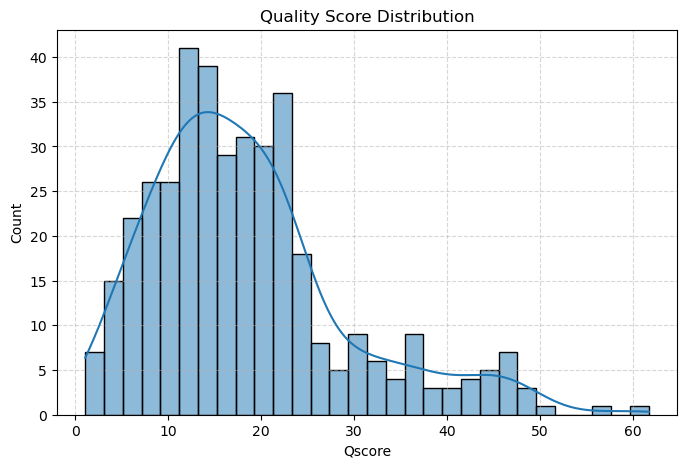

In [5]:

######## Computing quality score using adjustable weights 

# Weight definition for each metric (Adjust the weights)
w = {"OHA_30":0.50, "THV_15":0.15, "CHV_15":0.30, "BCR":0.05}

# Calculate quality score and add to dataframe 
df["Qscore"]= (df[list(w)].mul(w).sum(axis=1))

######## Plotting for visual inspection allowing wieghts and thresholds adjustment

# 4d scattered plot (interactive)
fig = px.scatter_3d(df, x="OHA_30", y="THV_15", z="CHV_15", color="BCR", hover_name="sub", opacity=0.8)
fig.update_layout(scene=dict(xaxis_title="OHA_30 (%)", yaxis_title="THV_15 (%)", zaxis_title="CHV_15 (%)"), title="EEG QC space")
fig.show()

# Distribution plot 
plt.figure(figsize=(8, 5))
sns.histplot(df["Qscore"], bins=30, kde=True)
plt.xlabel("Qscore")
plt.title("Quality Score Distribution")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [6]:
######## Setting the thresholds for subject labeling as good - ok - bad 

# Label subjects (Adjust the thresholds) !! 
df['quality_label'] = df['Qscore'].apply(lambda s: 'Good' if s <=15 else 'OK' if s<=25 else 'Bad')

# Exclude subjects based on quality label and BCR
exclude = df[(df['quality_label']=='Bad') | (df['BCR']>=20)]['sub'].tolist()

# Save QC of subjects to csv file
df.to_csv(os.path.join(paths['deriv'], 'quality_control.csv'), index=False)

print("Number of subjects excluded based on quality label and BCR threshold: ", len(exclude))


Number of subjects excluded based on quality label and BCR threshold:  165


## **Preprocessing and ERN analysis**


Subject sub-ES06NK11 already preprocessed :)!, skipping...
Subject sub-EN05ED14 already preprocessed :)!, skipping...
Subject sub-RT04KE01 already preprocessed :)!, skipping...
Subject sub-VA05AS27 already preprocessed :)!, skipping...
Subject sub-LS08LF22 excluded because too noisy :(, skipping...
Subject sub-KE07NZ01 excluded because too noisy :(, skipping...
Subject sub-SA05AH22 already preprocessed :)!, skipping...
Subject sub-ER05AS20 already preprocessed :)!, skipping...
Subject sub-NN08ER22 already preprocessed :)!, skipping...
Subject sub-US08RI28 excluded because too noisy :(, skipping...
Subject sub-ER07ND12 already preprocessed :)!, skipping...
Processing subject sub-RS06RS22...


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning:

pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95454
    Range : 0 ... 95453 =      0.000 ...   381.812 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'CP1']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 100.0 mm
Computing interpolation matrix from 55 sensor positions
Interpolating 3 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.



Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


ASR failed for sub-RS06RS22: cannot reshape array of size 1877112 into shape (559,3364), skipping...
Subject sub-ER09AS01 excluded because too noisy :(, skipping...
Processing subject sub-SE05ZI24...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=95889
    Range : 0 ... 95888 =      0.000 ...   383.552 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'AF7', 'C4', 'TP8', 'P6', 'PO8', 'PO4', 'OZ']


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning:

pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.



Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 100.0 mm
Computing interpolation matrix from 50 sensor positions
Interpolating 8 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=95889
    Range : 0 ... 95888 =      0.000 ...   383.552 secs
Ready.
Added the following bipolar channels:
VEOG
Fitting ICA to data using 58 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 2.6s.
Using EOG channel: VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Using EOG channel: HEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


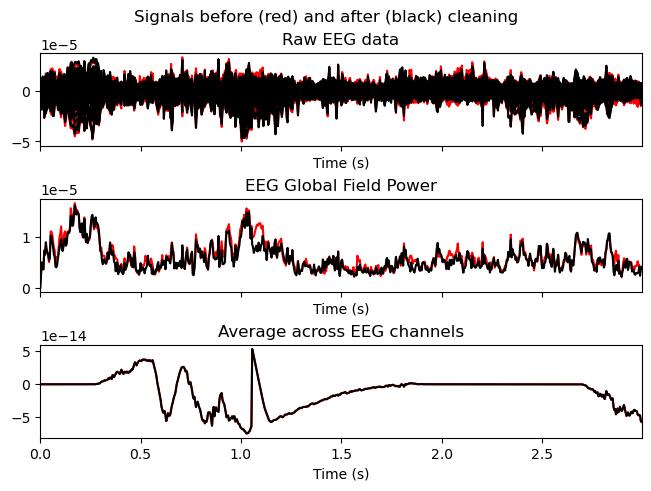

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 58 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Used Annotations descriptions: [np.str_('100'), np.str_('104'), np.str_('106'), np.str_('107'), np.str_('109'), np.str_('110'), np.str_('114'), np.str_('116'), np.str_('117'), np.str_('119'), np.str_('120'), np.str_('124'), np.str_('126'), np.str_('127'), np.str_('129'), np.str_('130

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.1s finished


3 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/58 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/58 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

Dropped 81 epochs: 0, 4, 5, 6, 7, 24, 26, 27, 28, 42, 43, 61, 62, 74, 75, 76, 77, 78, 80, 81, 87, 88, 93, 94, 96, 97, 99, 100, 101, 104, 105, 107, 108, 115, 116, 119, 120, 127, 131, 136, 137, 138, 139, 140, 143, 144, 149, 150, 155, 156, 158, 159, 160, 173, 174, 183, 188, 189, 190, 200, 201, 205, 206, 207, 208, 213, 214, 227, 228, 230, 231, 246, 247, 248, 255, 256, 257, 264, 265, 267, 268


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:117: RuntimeWarning:

This filename (/Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/sub-SE05ZI24/sub-SE05ZI24_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:157: RuntimeWarning:

This filename (/Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/sub-SE05ZI24/_desc-sub-SE05ZI24-evokedCorrect_eeg.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:158: RuntimeWarning:

This filename (/Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/sub-SE05ZI24/_desc-sub-SE05ZI24-evokedIncorrect_eeg.fif) does not conform to MNE naming conventions. All evoked fi

Subject sub-SE05ZI24 preprocessed successfully :)!
Found 3 significant peaks


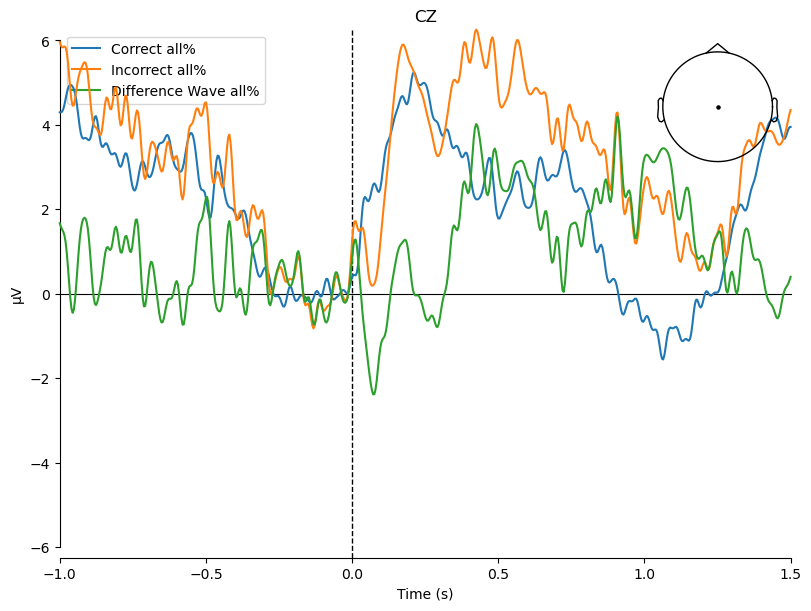

Saved plot for all% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-SE05ZI24_cong-all_plot.png
Found 3 significant peaks


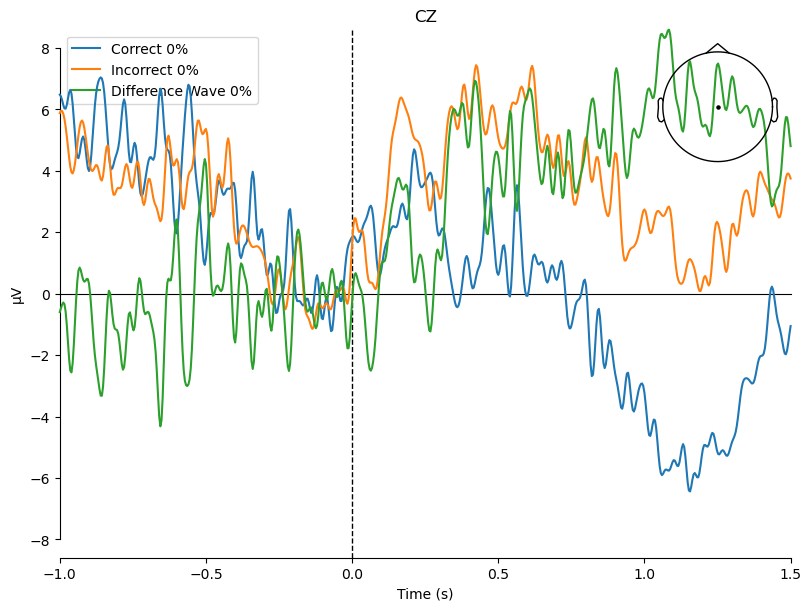

Saved plot for 0% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-SE05ZI24_cong-0_plot.png
Found 4 significant peaks


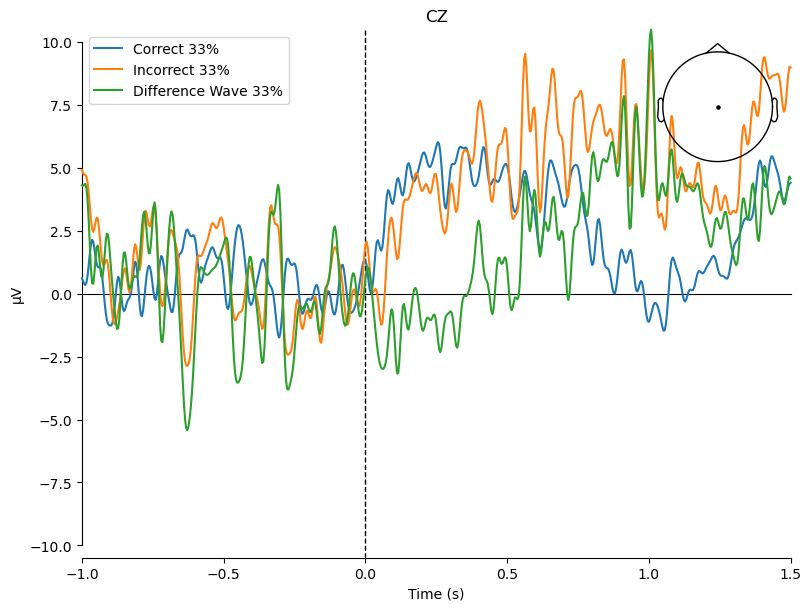

Saved plot for 33% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-SE05ZI24_cong-33_plot.png
Found 5 significant peaks


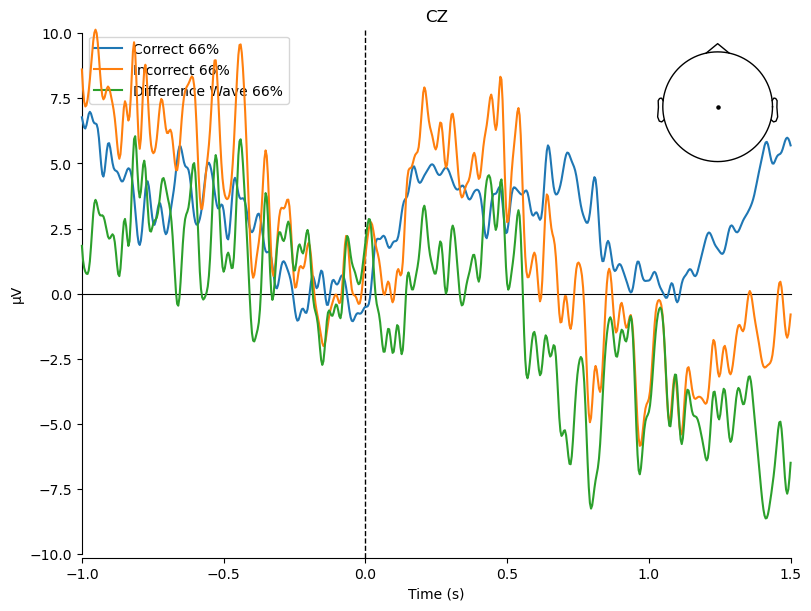

Saved plot for 66% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-SE05ZI24_cong-66_plot.png
Found 2 significant peaks


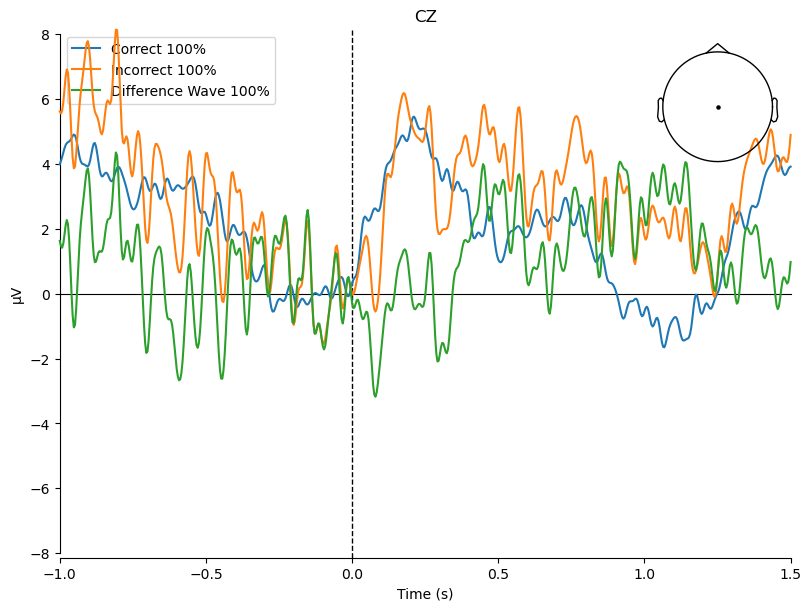

Saved plot for 100% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-SE05ZI24_cong-100_plot.png
Processing done :) Saved ERN values for sub-SE05ZI24 to /Users/zayneb/Desktop/eegmanyanalysts/results/ern_values
Subject sub-ER06AN07 excluded because too noisy :(, skipping...
Subject sub-CK07NK21 excluded because too noisy :(, skipping...
Processing subject sub-OW06NZ10...


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning:

pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=99113
    Range : 0 ... 99112 =      0.000 ...   396.448 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2', 'AF8', 'T8']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 100.0 mm
Computing interpolation matrix from 54 sensor positions
Interpolating 4 sensors


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

Limited 2 annotation(s) that were expanding outside the data range.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.



EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.2s finished


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=99113
    Range : 0 ... 99112 =      0.000 ...   396.448 secs
Ready.
Added the following bipolar channels:
VEOG
Fitting ICA to data using 58 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 1.6s.
Using EOG channel: VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
D

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Using EOG channel: HEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 58 PCA components


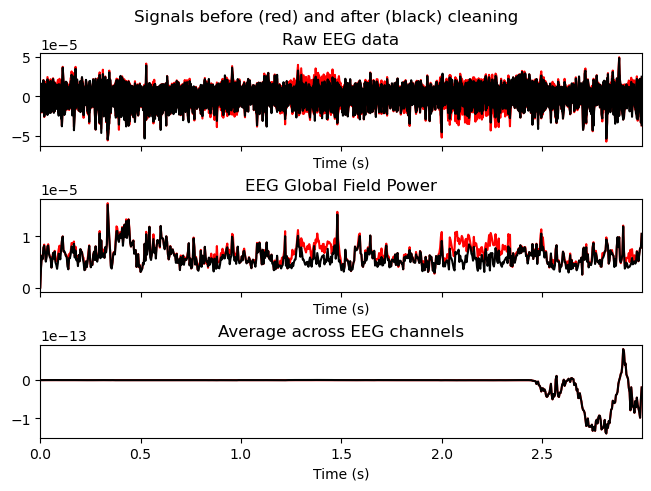

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 58 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Used Annotations descriptions: [np.str_('100'), np.str_('104'), np.str_('107'), np.str_('109'), np.str_('110'), np.str_('114'), np.str_('116'), np.str_('117'), np.str_('119'), np.str_('120'), np.str_('124'), np.str_('126'), np.str_('127'), np.str_('129'), np.str_('130'), np.str_('134'

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.3s finished


Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 875 events and 626 original time points ...
2 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/58 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/58 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4


  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

Dropped 108 epochs: 0, 4, 5, 6, 7, 8, 13, 14, 20, 21, 24, 26, 39, 40, 41, 42, 43, 46, 47, 48, 49, 50, 56, 57, 58, 59, 60, 62, 69, 70, 75, 76, 78, 79, 80, 89, 90, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 116, 117, 132, 133, 134, 135, 136, 137, 140, 141, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 161, 164, 173, 174, 181, 182, 188, 189, 190, 191, 197, 198, 206, 207, 215, 216, 217, 218, 226, 227, 228, 230, 232, 243, 244, 245, 249, 258, 259, 260, 267, 268, 270, 271, 272, 273, 274, 275, 276
Subject sub-OW06NZ10 preprocessed successfully :)!
Found 2 significant peaks


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:117: RuntimeWarning:

This filename (/Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/sub-OW06NZ10/sub-OW06NZ10_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:157: RuntimeWarning:

This filename (/Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/sub-OW06NZ10/_desc-sub-OW06NZ10-evokedCorrect_eeg.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:158: RuntimeWarning:

This filename (/Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/sub-OW06NZ10/_desc-sub-OW06NZ10-evokedIncorrect_eeg.fif) does not conform to MNE naming conventions. All evoked fi

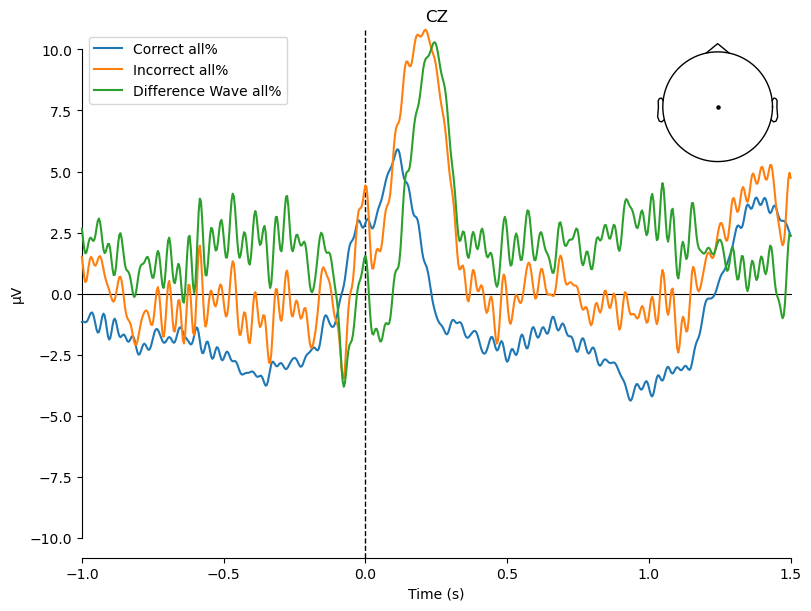

Saved plot for all% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-OW06NZ10_cong-all_plot.png
Found 4 significant peaks


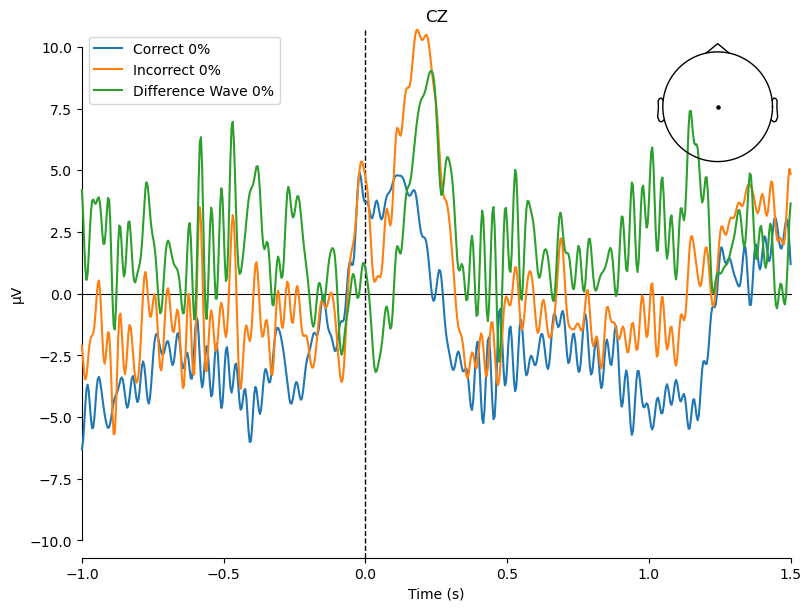

Saved plot for 0% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-OW06NZ10_cong-0_plot.png
Found 2 significant peaks


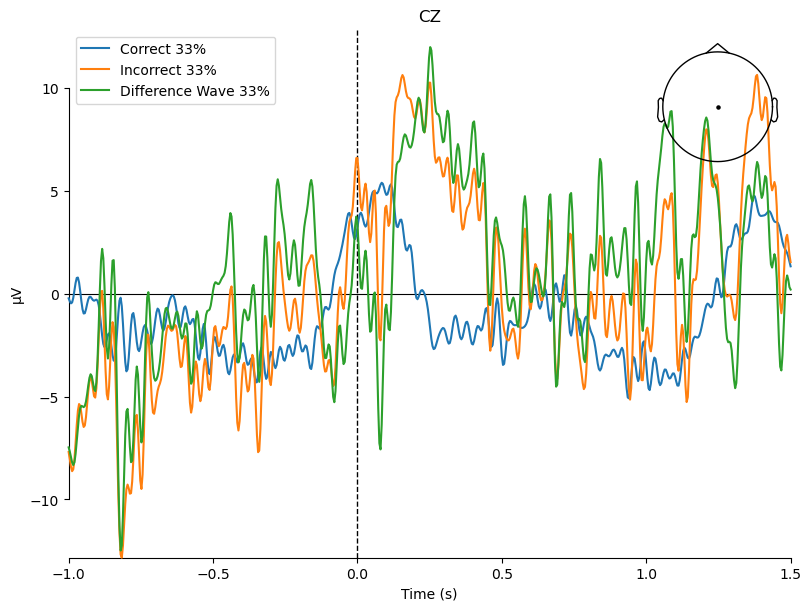

Saved plot for 33% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-OW06NZ10_cong-33_plot.png
Found 2 significant peaks


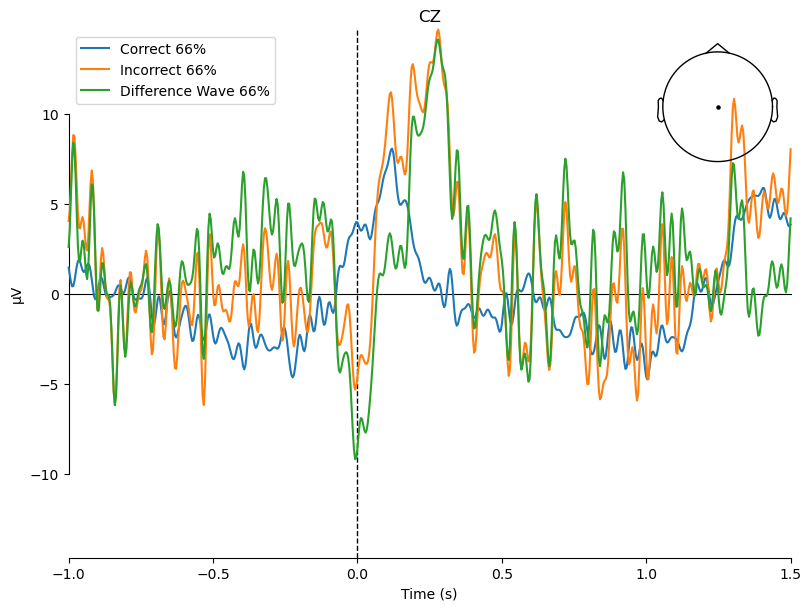

Saved plot for 66% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-OW06NZ10_cong-66_plot.png
Found 2 significant peaks


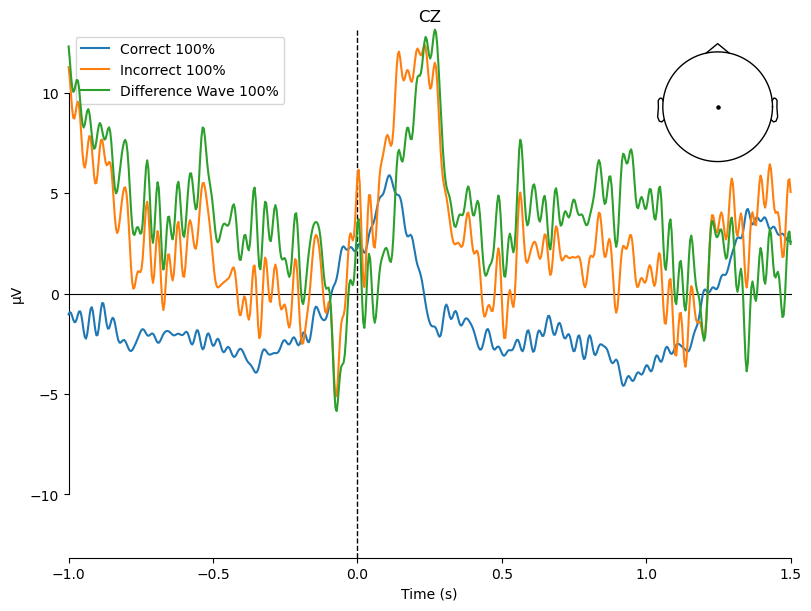

Saved plot for 100% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-OW06NZ10_cong-100_plot.png
Processing done :) Saved ERN values for sub-OW06NZ10 to /Users/zayneb/Desktop/eegmanyanalysts/results/ern_values
Subject sub-DE05LI03 excluded because too noisy :(, skipping...
Processing subject sub-RT06AN02...


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning:

pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=100883
    Range : 0 ... 100882 =      0.000 ...   403.528 secs
Ready.
LOF: Detected bad channel(s): ['FP1', 'FP2']
Setting channel interpolation method to {'eeg': 'spline'}.


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

Limited 2 annotation(s) that were expanding outside the data range.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.



Interpolating bad channels.
    Automatic origin fit: head of radius 100.0 mm
Computing interpolation matrix from 56 sensor positions
Interpolating 2 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.2s finished


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=100883
    Range : 0 ... 100882 =      0.000 ...   403.528 secs
Ready.
Added the following bipolar channels:
VEOG
Fitting ICA to data using 58 channels (please be patient, this may take a while)
Selecting by number: 25 components
Fitting ICA took 2.5s.
Using EOG channel: VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 58 PCA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 58 PCA components


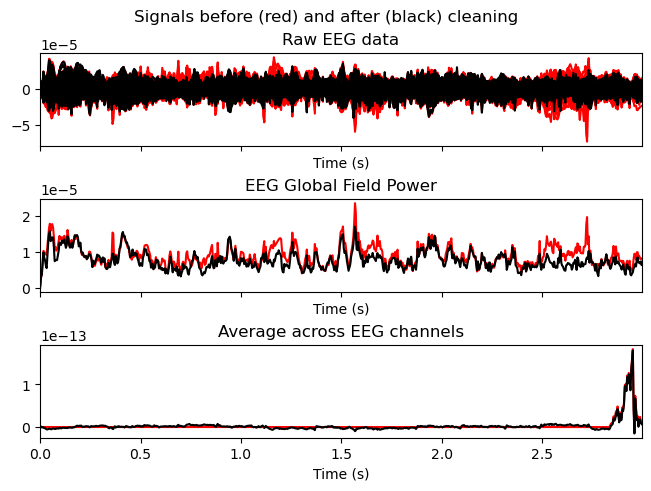

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 58 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)

Used Annotations descriptions: [np.str_('100'), np.str_('104'), np.str_('106'), np.str_('107'), np.str_('109'), np.str_('110'), np.str_('114'), np.str_('116'), np.str_('117'), np.str_('119'), np.str_('120'), np.str_('124'), np.str_('126'), np.str_('127'), np.str_('129'), np.str_('130

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.2s finished


2 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/58 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/58 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=32


  0%|          | Repairing epochs : 0/286 [00:00<?,       ?it/s]

Dropped 4 epochs: 187, 188, 199, 224


/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:117: RuntimeWarning:

This filename (/Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/sub-RT06AN02/sub-RT06AN02_desc-epochs_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:157: RuntimeWarning:

This filename (/Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/sub-RT06AN02/_desc-sub-RT06AN02-evokedCorrect_eeg.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:158: RuntimeWarning:

This filename (/Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/sub-RT06AN02/_desc-sub-RT06AN02-evokedIncorrect_eeg.fif) does not conform to MNE naming conventions. All evoked fi

Subject sub-RT06AN02 preprocessed successfully :)!
Found 2 significant peaks


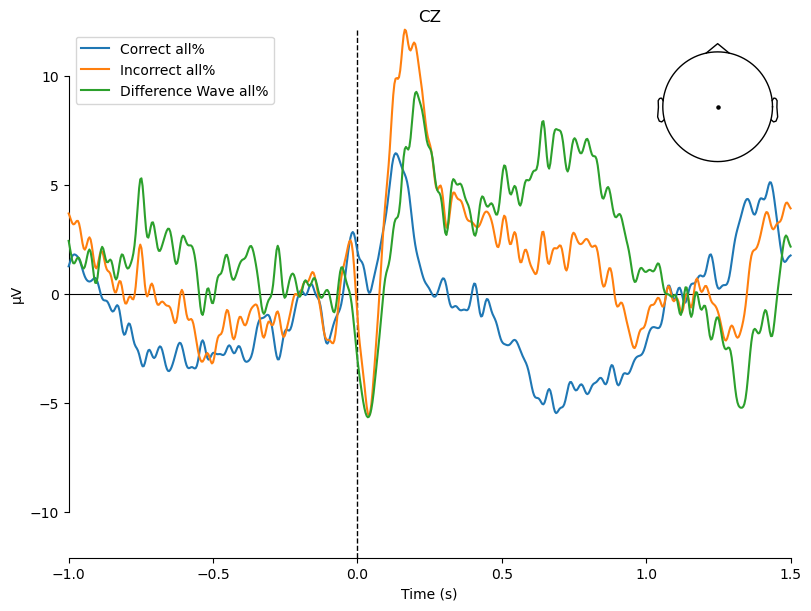

Saved plot for all% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-RT06AN02_cong-all_plot.png
Found 3 significant peaks


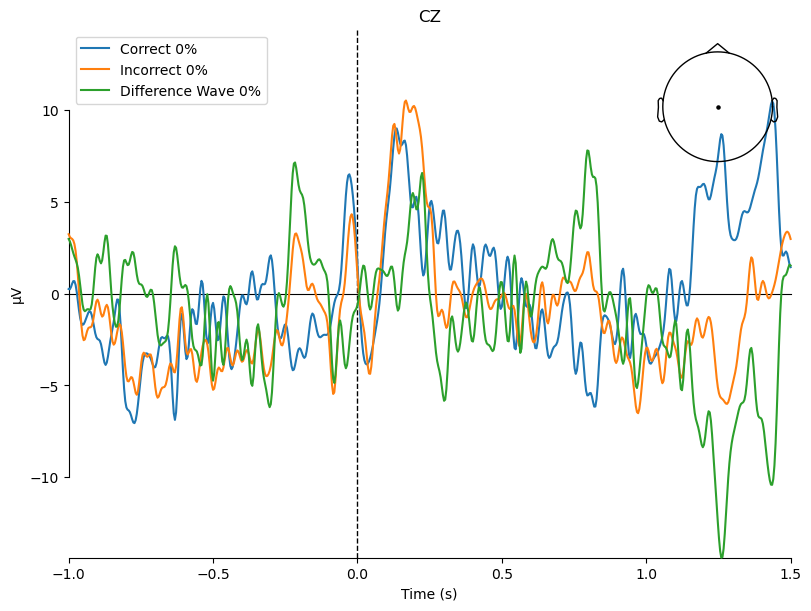

Saved plot for 0% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-RT06AN02_cong-0_plot.png
Found 2 significant peaks


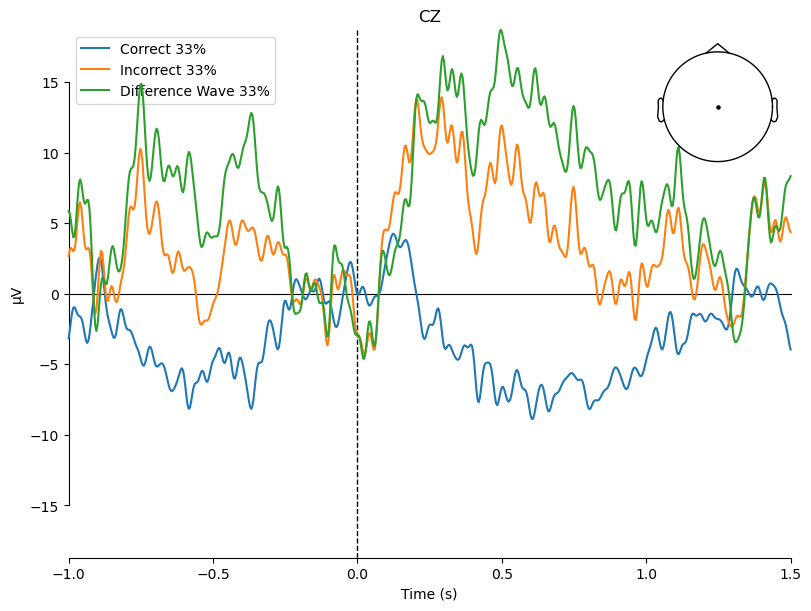

Saved plot for 33% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-RT06AN02_cong-33_plot.png
Found 3 significant peaks


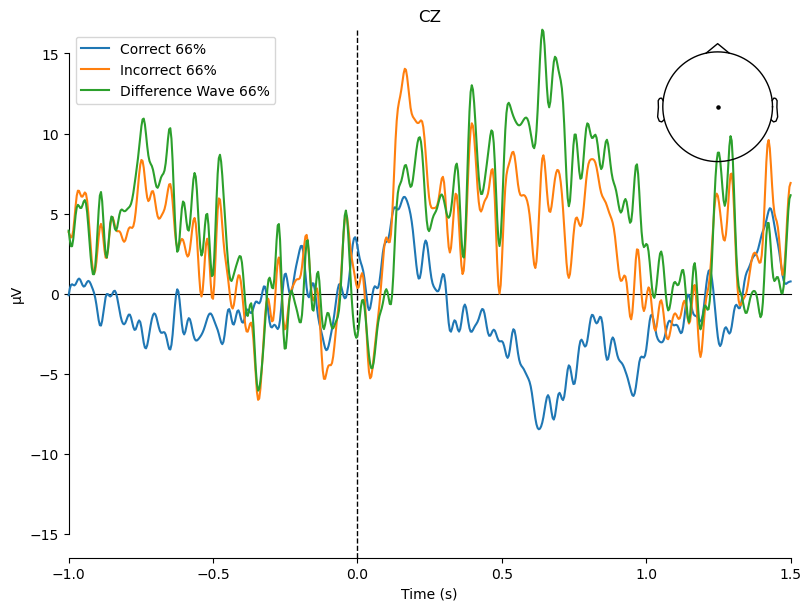

Saved plot for 66% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-RT06AN02_cong-66_plot.png
Found 2 significant peaks


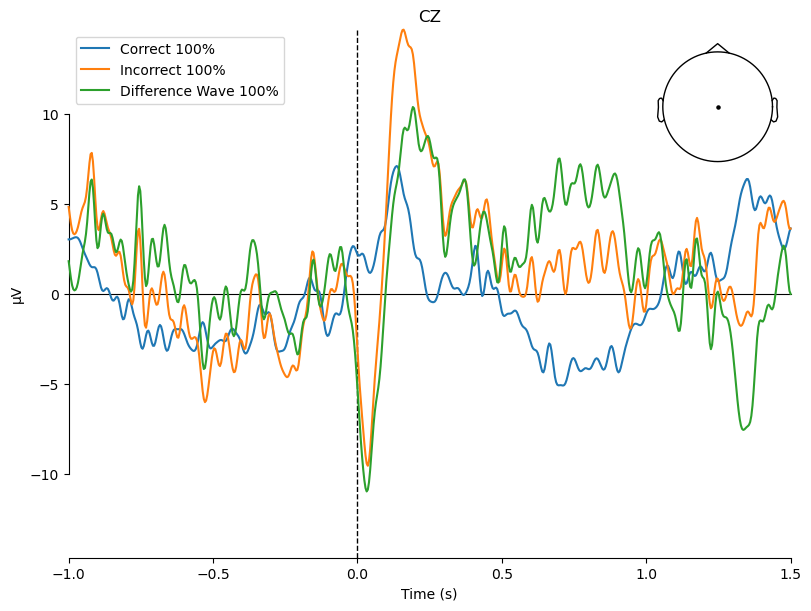

Saved plot for 100% → /Users/zayneb/Desktop/eegmanyanalysts/derivatives/ernpipeline/plots/sub-RT06AN02_cong-100_plot.png
Processing done :) Saved ERN values for sub-RT06AN02 to /Users/zayneb/Desktop/eegmanyanalysts/results/ern_values
Processing subject sub-ER06IS22...


/opt/anaconda3/envs/mne_env/lib/python3.10/site-packages/pymatreader/utils.py:283: UserWarning:

pymatreader cannot import Matlab string variables. Please convert these variables to char arrays in Matlab.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.

/var/folders/yf/nzb3h5md40v2gd860y7tqqmm0000gn/T/ipykernel_11696/4182133572.py:20: RuntimeWarning:

Not setting position of 1 eog channel found in montage:
['VOGbelow']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=1, n_times=90406
    Range : 0 ... 90405 =      0.000 ...   361.620 secs
Ready.
LOF: Detected bad channel(s): ['F1', 'F5', 'FC2', 'C1', 'TP8', 'PO7', 'O2', 'OZ']
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 100.0 mm
Computing interpolation matrix from 50 sensor positions
Interpolating 8 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB c

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.2s finished


In [ ]:
subject_list = files

for participant in subject_list : 
    
    # Define preprocessed epochs file
    preproc_file = epochs_file(participant)
    # Skip if QC excluded or already preprocessed
    if participant in exclude or os.path.exists(preproc_file):
        reason = "excluded because too noisy :(" if participant in exclude else "already preprocessed :)!"
        print(f"Subject {participant} {reason}, skipping...")
        continue
    
    #################
    # PREPROCESSING #
    #################
    
    print(f"Processing subject {participant}...")
  
    #load subject
    raw = mne.io.read_raw_eeglab(raw_set_path(participant), preload=True, verbose=False)
    unused_channels = ['MASTl','MASTr']
    raw = raw.drop_channels(unused_channels)

    #Adding HEOG as EOG
    heog_data = raw.copy().pick_channels(['F7','F8']).get_data()
    heog = heog_data[0] - heog_data[1]
    heog_info = mne.create_info(['HEOG'], raw.info['sfreq'], 'eog')
    heog_raw = mne.io.RawArray(heog[np.newaxis,:], heog_info)
    raw_heog = raw.copy()
    raw_heog = raw_heog.add_channels([heog_raw], force_update_info=True)
  
    # automatically detect bad channels using Local Outlier Factof (LOF), interpolate and keep them
    bad_channels = mne.preprocessing.find_bad_channels_lof(raw_heog, n_neighbors=20, picks=None, metric="euclidean", threshold=1.5, return_scores=False, verbose=None)
    bad_channels_raw = raw_heog.copy()
    for ch in bad_channels:
        if ch not in raw.info["bads"]:
            bad_channels_raw.info["bads"].append(ch)

    # computing the ratio of bad channels to good channels (BCR)
    n_bads = len(bad_channels_raw.info["bads"])
    n_eeg = len(mne.pick_types(raw.info, eeg=True))
    n_goods = n_eeg - n_bads
    BCR = n_bads / n_goods
    
    raw_interp = bad_channels_raw.copy().interpolate_bads()
    
    # Rereferencing to average 
    raw_interp.set_eeg_reference('average')
    
    # filtering to remove slow drifts
    filt_raw = raw_interp.copy()
    filt_raw.load_data().filter(l_freq=1., h_freq=None)
    
    # cleaning with artifact subspace reconstruction (ASR)
    try : 
        eeg_picks = mne.pick_types(filt_raw.info, eeg=True)
        asr = asrpy.ASR(sfreq=filt_raw.info['sfreq'], cutoff=15)
        asr.fit(filt_raw.copy().pick(eeg_picks))
        asr_raw = asr.transform(filt_raw.copy())
    except Exception as e:
        print(f"ASR failed for {participant}: {e}, skipping...")
        continue


    # VEOG: VOG_below and FP1 
    raw_eog = asr_raw.copy()
    raw_eog = mne.set_bipolar_reference(asr_raw, anode="VOGbelow", cathode="FP1", ch_name='VEOG', copy=False, drop_refs=False)
    raw_eog.set_channel_types({"VEOG": 'eog'})
    raw_eog.drop_channels(['VOGbelow'])

    # ICA - Only computing the 25 first components for speed issue, using 42 as a random seed
    ica = mne.preprocessing.ICA(n_components=25, max_iter=1000, random_state=42)
    
    # applying ICA only to EEG channels only, to filtered raw
    ica.fit(raw_eog)
    
    # Automatically detect bad EOG components using correlation 
    eog_idx_v, eog_scores_v = ica.find_bads_eog(raw_eog, ch_name='VEOG', measure="zscore", threshold=3)
    eog_idx_h, eog_scores_h = ica.find_bads_eog(raw_eog, ch_name='HEOG', measure="zscore", threshold=3)
    ica.exclude = eog_idx_v + eog_idx_h 
    clean_raw = ica.apply(raw_eog.copy())
    ica.plot_overlay(raw_eog, exclude = ica.exclude, picks="eeg")

    postica = ica.apply(raw_interp)
    prep_continuous = postica.filter(l_freq=.1, h_freq=30)
    
    # defining epochs of interest 
    events, event_id = mne.events_from_annotations(prep_continuous)
    epochs = mne.Epochs(prep_continuous, events, event_id, tmin=-1, tmax=1.5, baseline= (-.2, 0), preload=True, event_repeated="drop")
    
    correct_events = [e for e in ["106", "107", "116", "117", "126", "127", "136", "137"] if e in epochs.event_id]
    incorrect_events = [e for e in ["108", "109", "118", "119",  "128", "129", "138", "139"] if e in epochs.event_id]
    event_codes_of_interest = correct_events + incorrect_events
    epochs_of_interest = epochs[event_codes_of_interest]
    
    # applying autoreject on epochs of interest 
    ar = AutoReject()
    epochs_clean = ar.fit_transform(epochs_of_interest)
    
    # Track number of retained epochs
    n_retained_epochs = len(epochs_clean)
    n_total_epochs = len(epochs_of_interest)

    # Get reject log (based on original epochs)
    reject_log = ar.get_reject_log(epochs_of_interest)
    removed_indices = np.flatnonzero(reject_log.bad_epochs)   
    
    # Count incorrect trials per congruency
    trial_counts = {}
    for label, codes in [('0',['108','109']),('33',['118','119']),
                         ('66',['128','129']),('100',['138','139'])]:
        valid = [e for e in codes if e in epochs_clean.event_id]
        trial_counts[f'n_trials_incorrect_{label}pct'] = len(epochs_clean[valid]) if valid else 0

    # Save cleaned epochs to preproc folder
    os.makedirs(os.path.dirname(preproc_file), exist_ok=True)
    epochs_clean.save(preproc_file, overwrite=True)

    # Write summary
    summary = {'subject_ID': participant,
        'interpolated_channels': bad_channels_raw.info['bads'],
        'ica_excluded': np.unique(ica.exclude).tolist(),
        'n_total_epochs': n_total_epochs,
        'n_retained_epochs': n_retained_epochs,
        'removed_epoch_indices': removed_indices.tolist(),
        **trial_counts}
        
    with open(summary_txt_path(participant), 'w') as f:
        for k, v in summary.items():
            f.write(f"{k}: {v}\n")
         
    print(f"Subject {participant} preprocessed successfully :)!")

    #################
    #  PROCESSING   #
    #################

    # Only include event codes that exist in epochs.event_id
    codes = {
        'correct': [c for c in ["106","107","116","117","126","127","136","137"] if c in epochs_clean.event_id],
        'incorrect': [c for c in ["108","109","118","119","128","129","138","139"] if c in epochs_clean.event_id]
    }
    
    epochs_corr = epochs_clean[codes['correct']] if codes['correct'] else None
    epochs_inc  = epochs_clean[codes['incorrect']] if codes['incorrect'] else None
    
    ERP_corr = epochs_corr.average() if epochs_corr else None
    ERP_inc  = epochs_inc.average()  if epochs_inc  else None
    
    if ERP_corr: ERP_corr.comment = 'Correct'
    if ERP_inc:  ERP_inc.comment  = 'Incorrect'
    Diff = None
    if ERP_corr and ERP_inc:
        Diff = ERP_inc.copy(); Diff._data = ERP_inc._data - ERP_corr._data; Diff.comment='Difference Wave'
    
    # Save evokeds
    ERP_corr.save(evoked_file(participant, 'Correct'), overwrite=True)
    ERP_inc.save(evoked_file(participant, 'Incorrect'), overwrite=True)
    Diff.save(evoked_file(participant, 'dif'), overwrite=True)
    
   
    
    def compute_congruency_ERPs(epochs, congruency, participant, channel="CZ", plot_dir=out_plot):
        """
        Computes ERPs, Diff, mean_amp_diff, and plots + saves result for a given congruency level.

        Parameters:
        - epochs : mne.Epochs
        - congruency : str, one of ["0", "33", "66", "100", "all"]
        - participant : str, participant ID for filenames
        - channel : str
        - plot_dir : str, folder to save plots. If None, no saving.

        Returns:
        - ERP_correct, ERP_incorrect, Diff, mean_amp_diff
        """
        event_codes = {
            "0":    {"correct": ["106", "107"], "incorrect": ["108", "109"]},
            "33":   {"correct": ["116", "117"], "incorrect": ["118", "119"]},
            "66":   {"correct": ["126", "127"], "incorrect": ["128", "129"]},
            "100":  {"correct": ["136", "137"], "incorrect": ["138", "139"]},
            "all":  {"correct": ["106", "107", "116", "117", "126", "127", "136", "137"], "incorrect": ["108", "109", "118", "119", "128", "129", "138", "139"]}
        }

        if congruency not in event_codes:
            raise ValueError(f"Invalid congruency: {congruency}")

        correct_ids = [e for e in event_codes[congruency]["correct"] if e in epochs.event_id]
        incorrect_ids = [e for e in event_codes[congruency]["incorrect"] if e in epochs.event_id]

        epochs_correct = epochs[correct_ids] if correct_ids else None
        epochs_incorrect = epochs[incorrect_ids] if incorrect_ids else None

        def safe_avg(e, name):
            if e is not None and len(e) > 0:
                evoked = e.average()
                evoked.comment = name
                return evoked
            else:
                print(f"No epochs found for {name}")
                return None

        ERP_correct = safe_avg(epochs_correct, f"Correct {congruency}%")
        ERP_incorrect = safe_avg(epochs_incorrect, f"Incorrect {congruency}%")

        mean_amp_diff = None
        Diff = None

        if ERP_correct and ERP_incorrect:
            Diff = ERP_correct.copy()
            Diff._data = ERP_incorrect._data - ERP_correct._data
            Diff.comment = f"Difference Wave {congruency}%"

            # Peak detection in the 0–0.5 s window
            ch_idx = Diff.ch_names.index(channel)
            data = Diff.data[ch_idx]
            mask = (Diff.times >= 0) & (Diff.times <= 0.5)
            data_win = data[mask]
            times_win = Diff.times[mask]

            peak_locs, peak_vals = mne.preprocessing.peak_finder(data_win, extrema=-1)

            if len(peak_locs) > 0:
                # Take the strongest negative peak (minimum value)
                peak = np.argmin(peak_vals)
                peak_time = times_win[peak_locs[peak]]
                tmin_win = peak_time - 0.1
                tmax_win = peak_time + 0.1
                Diff_cropped = Diff.copy().pick(channel).crop(tmin_win, tmax_win)
                mean_amp_diff = Diff_cropped.data.mean(axis=1) * 1e6  
            else:
                mean_amp_diff = None

        # Plot & save
        if ERP_correct and ERP_incorrect and Diff and plot_dir:
            os.makedirs(plot_dir, exist_ok=True)
            out_plot = os.path.join(plot_dir, f"{participant}_cong-{congruency}_plot.png")
            fig = mne.viz.plot_compare_evokeds(
                [ERP_correct, ERP_incorrect, Diff], picks=channel
            )[0]
            fig.savefig(out_plot, dpi=300)
            print(f"Saved plot for {congruency}% → {out_plot}")

        return ERP_correct, ERP_incorrect, Diff, mean_amp_diff


    # Run congruency-specific analysis
    plot_dir = paths['plots']
    ern_vals = []
    for cong in ["all","0","33","66","100"]:
        ERPc, ERPi, DIF, mean_amp = compute_congruency_ERPs(epochs_clean, cong, participant, plot_dir=plot_dir)
        ern_vals.append((cong, mean_amp[0] if mean_amp is not None else np.nan))
        
    # save ERPs in tsv file 
    csv_dir = os.path.join(paths['results'], 'ern_values')
    os.makedirs(csv_dir, exist_ok=True)
    with open(os.path.join(csv_dir, f"{participant}_desc-ernvalues.tsv"), 'w', newline='') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(["Condition","MeanAmp_µV"])
        writer.writerows(ern_vals)
        
    print(f"Processing done :) Saved ERN values for {participant} to {csv_dir}")
   